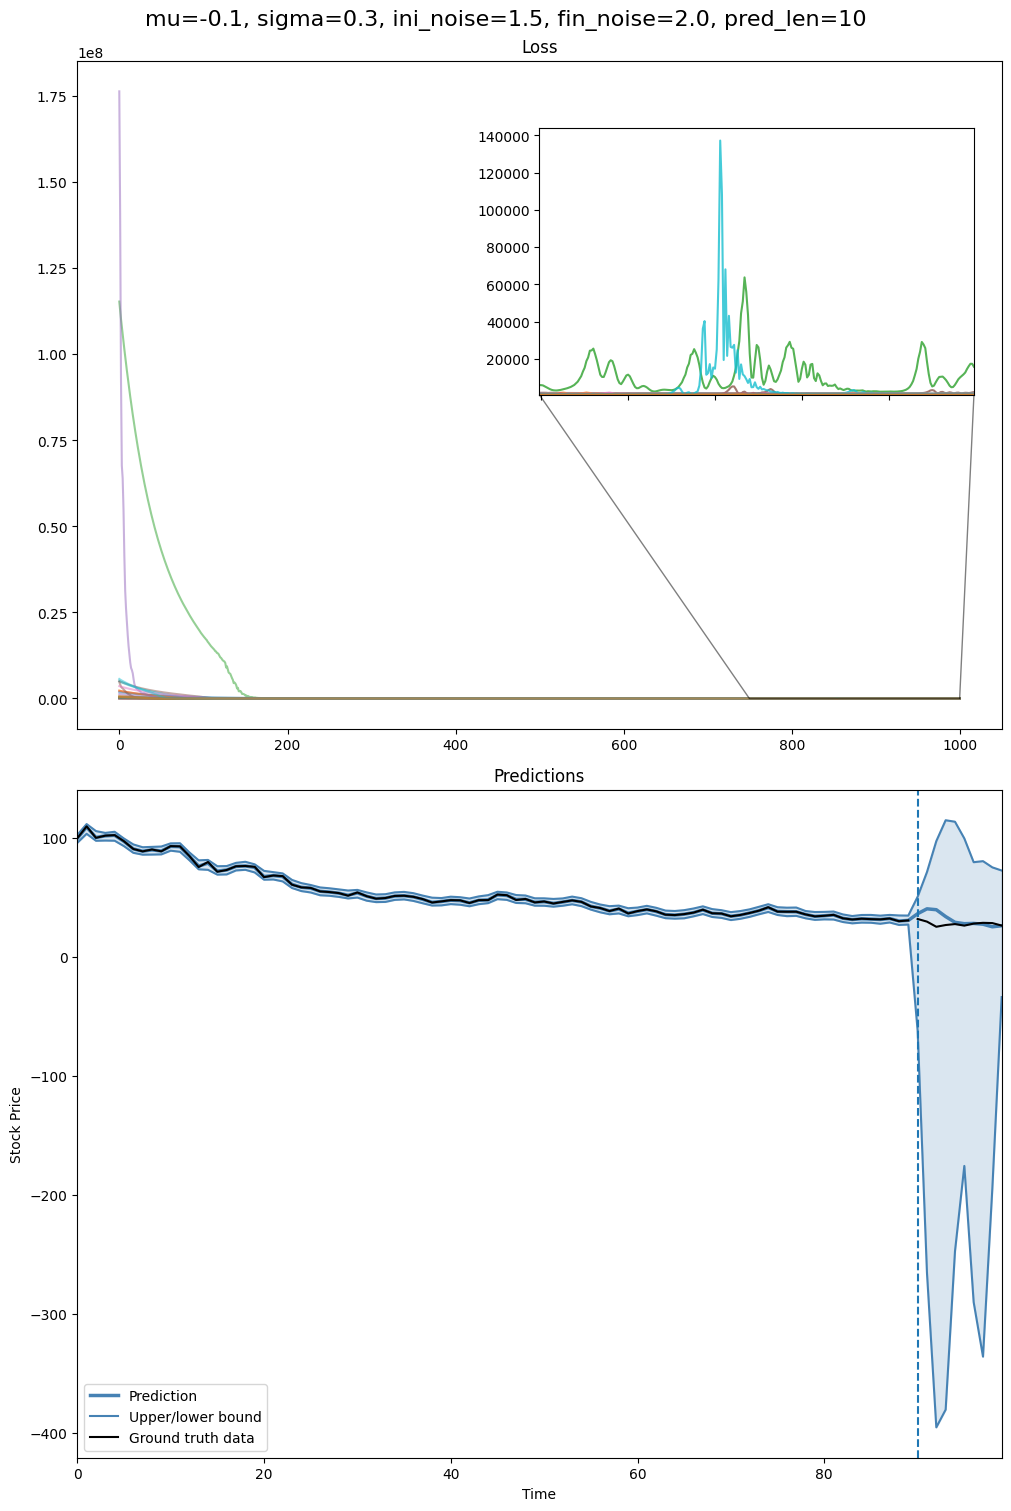

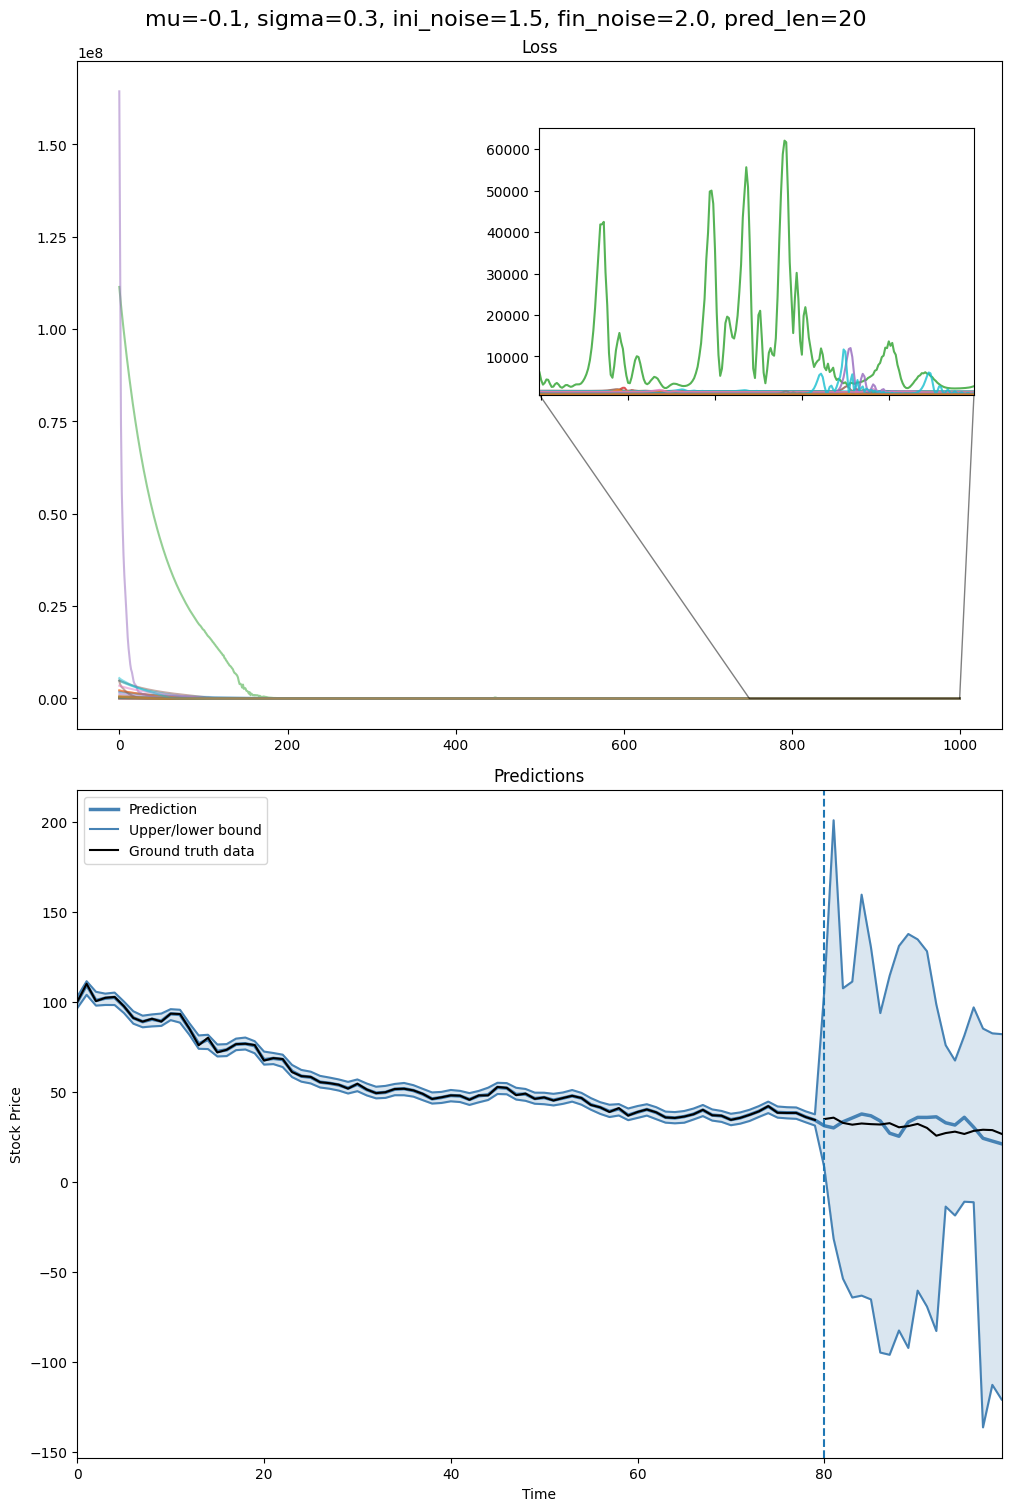

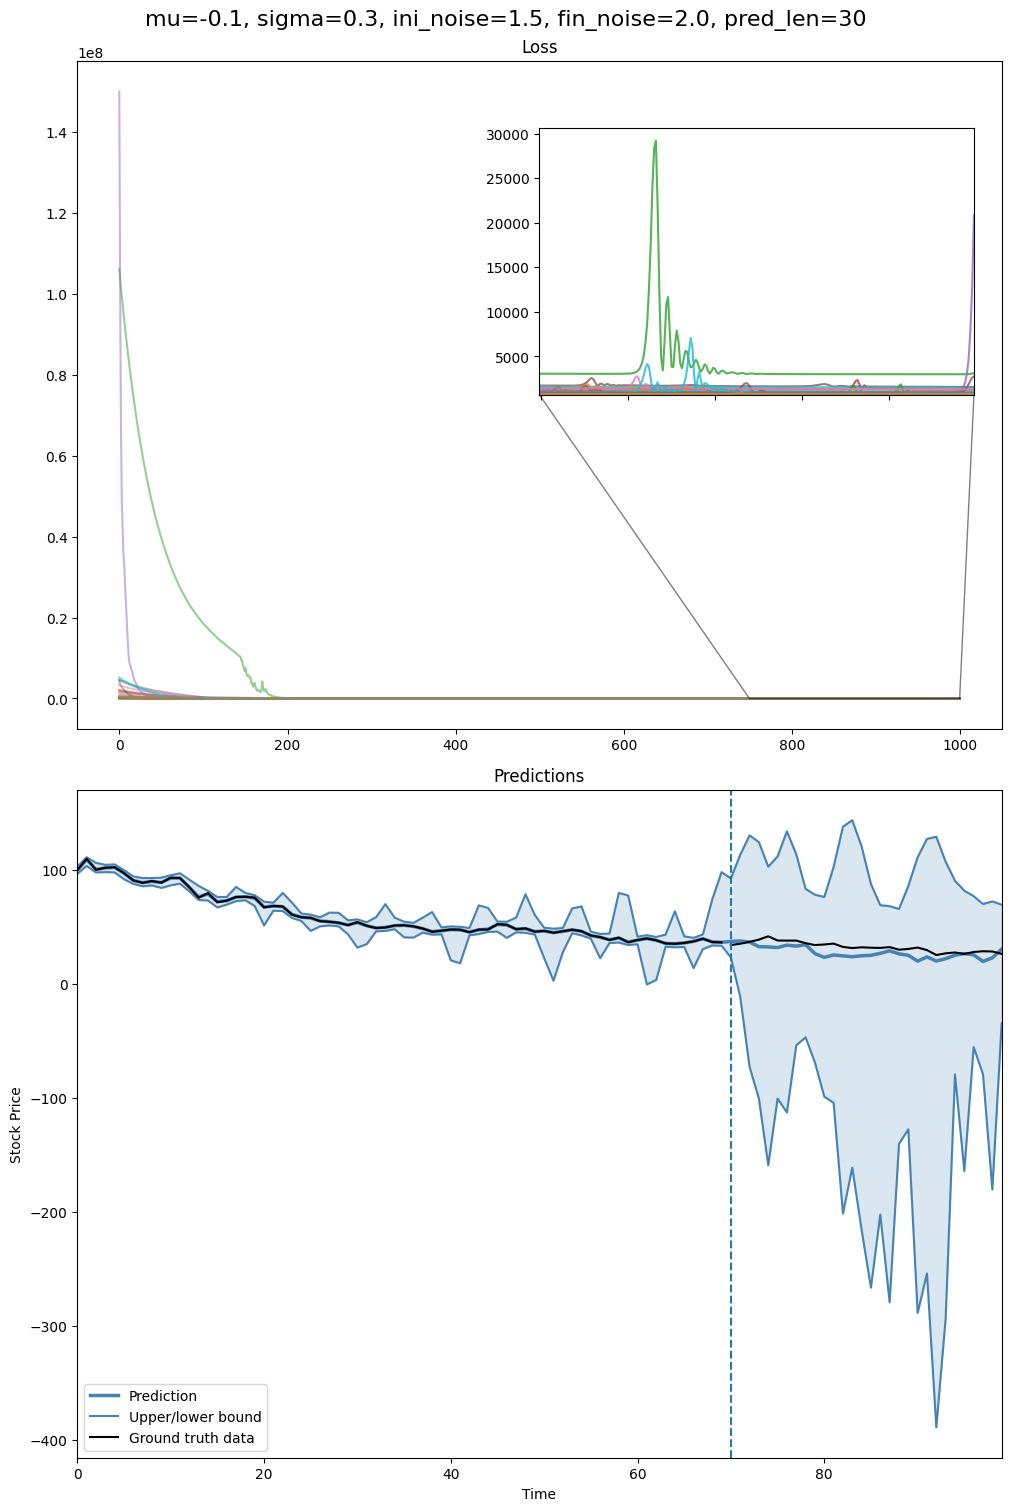

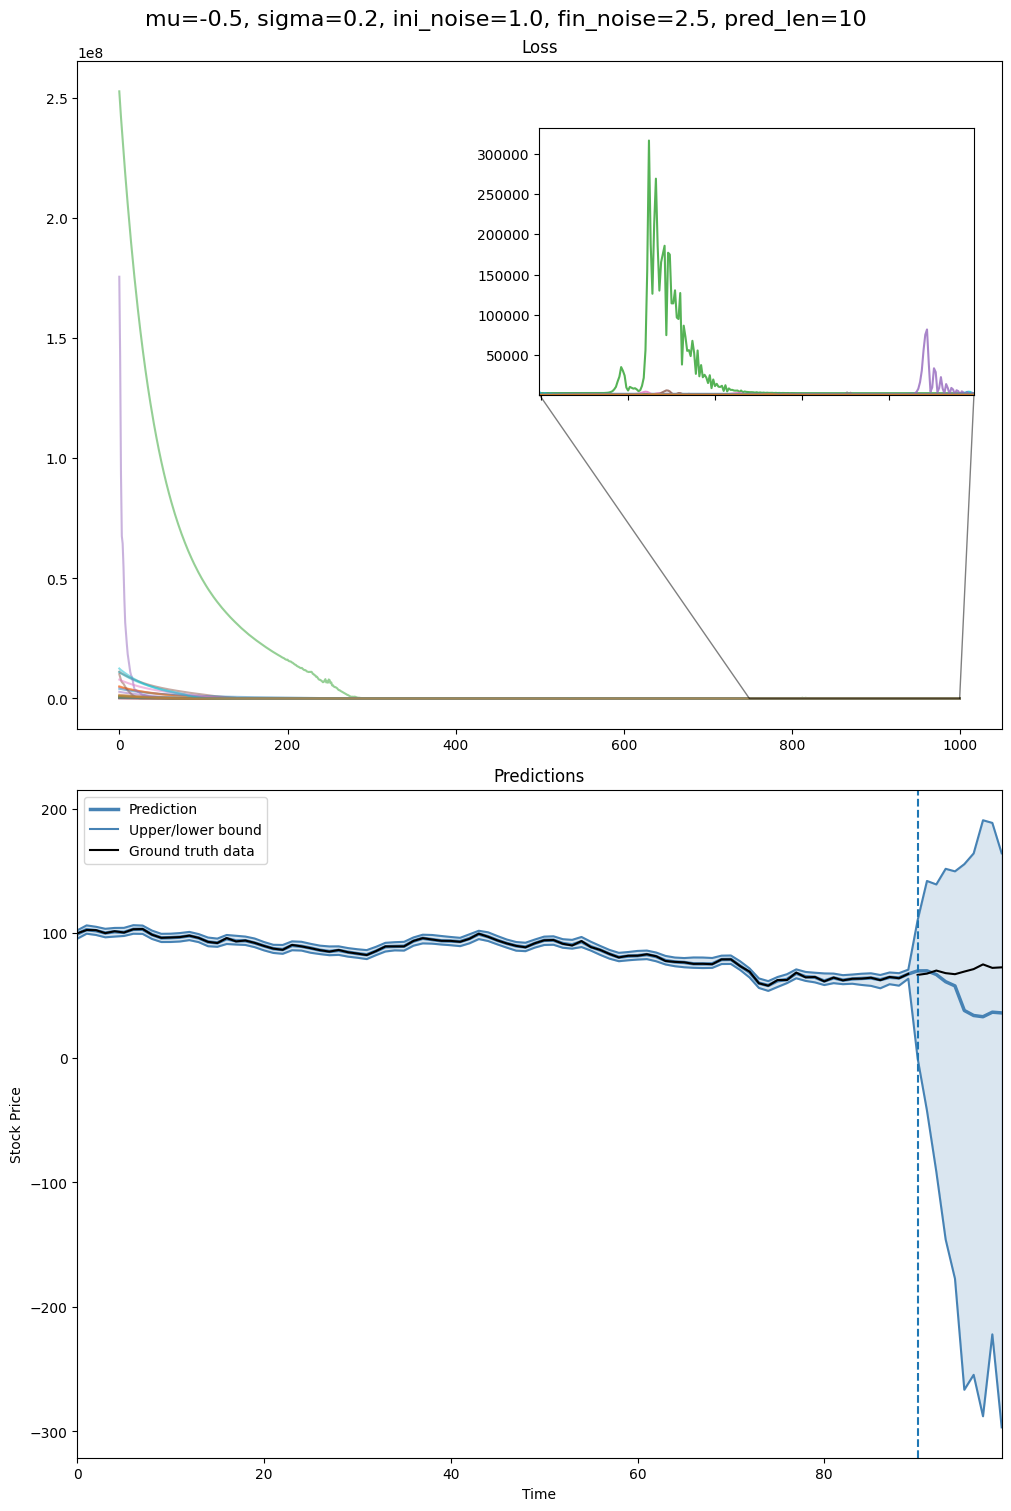

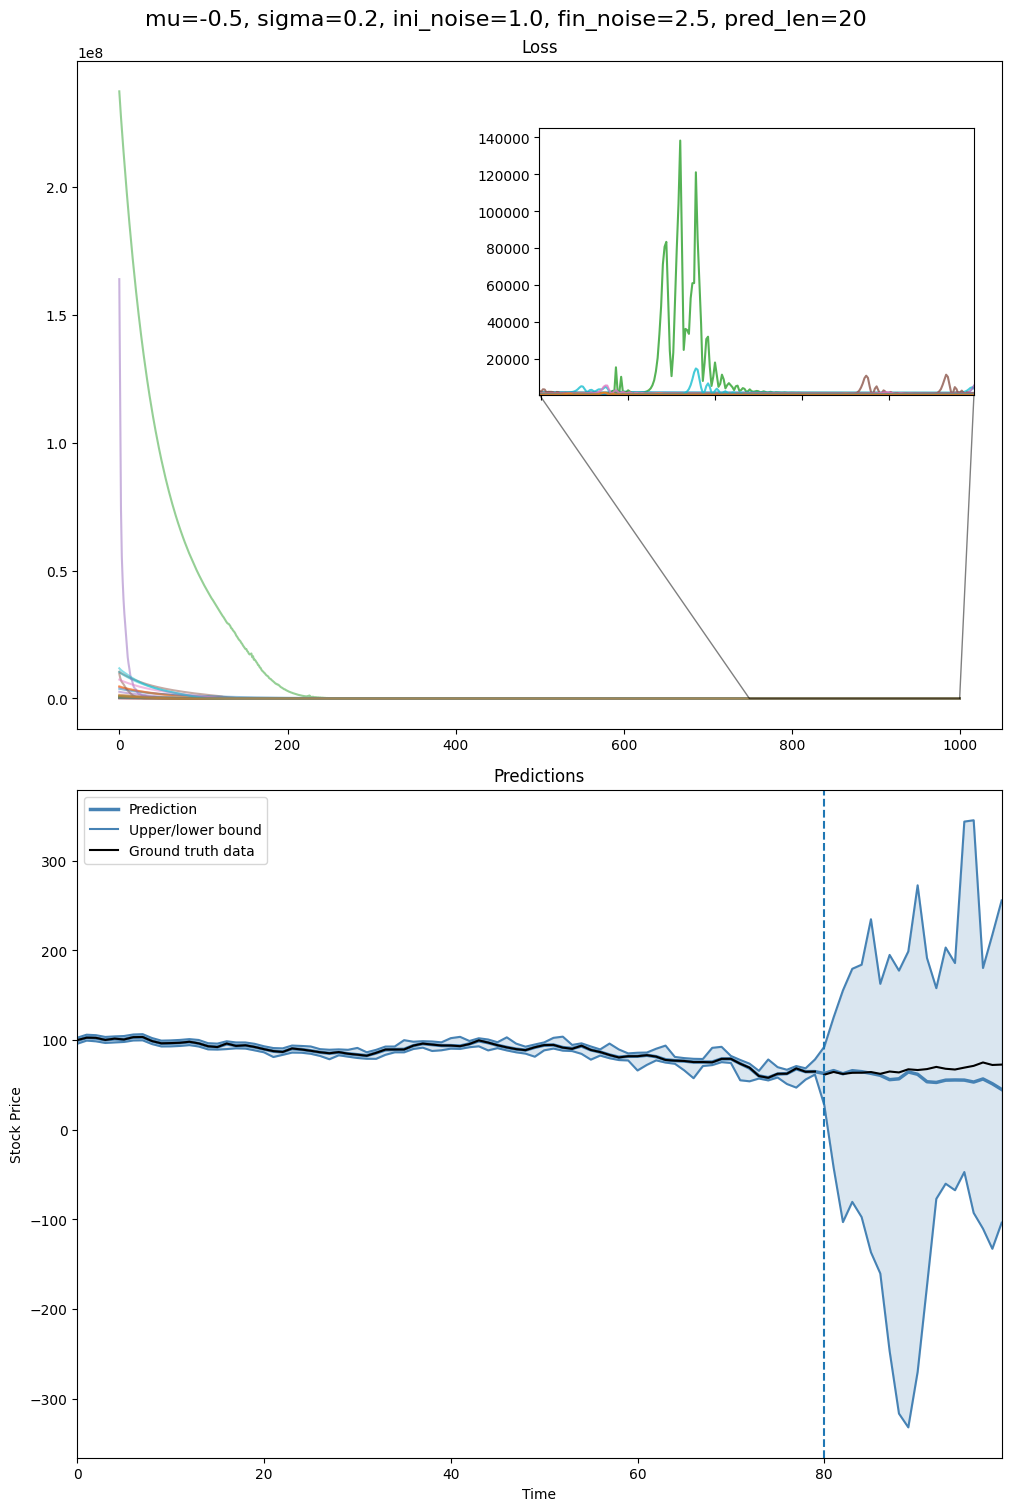

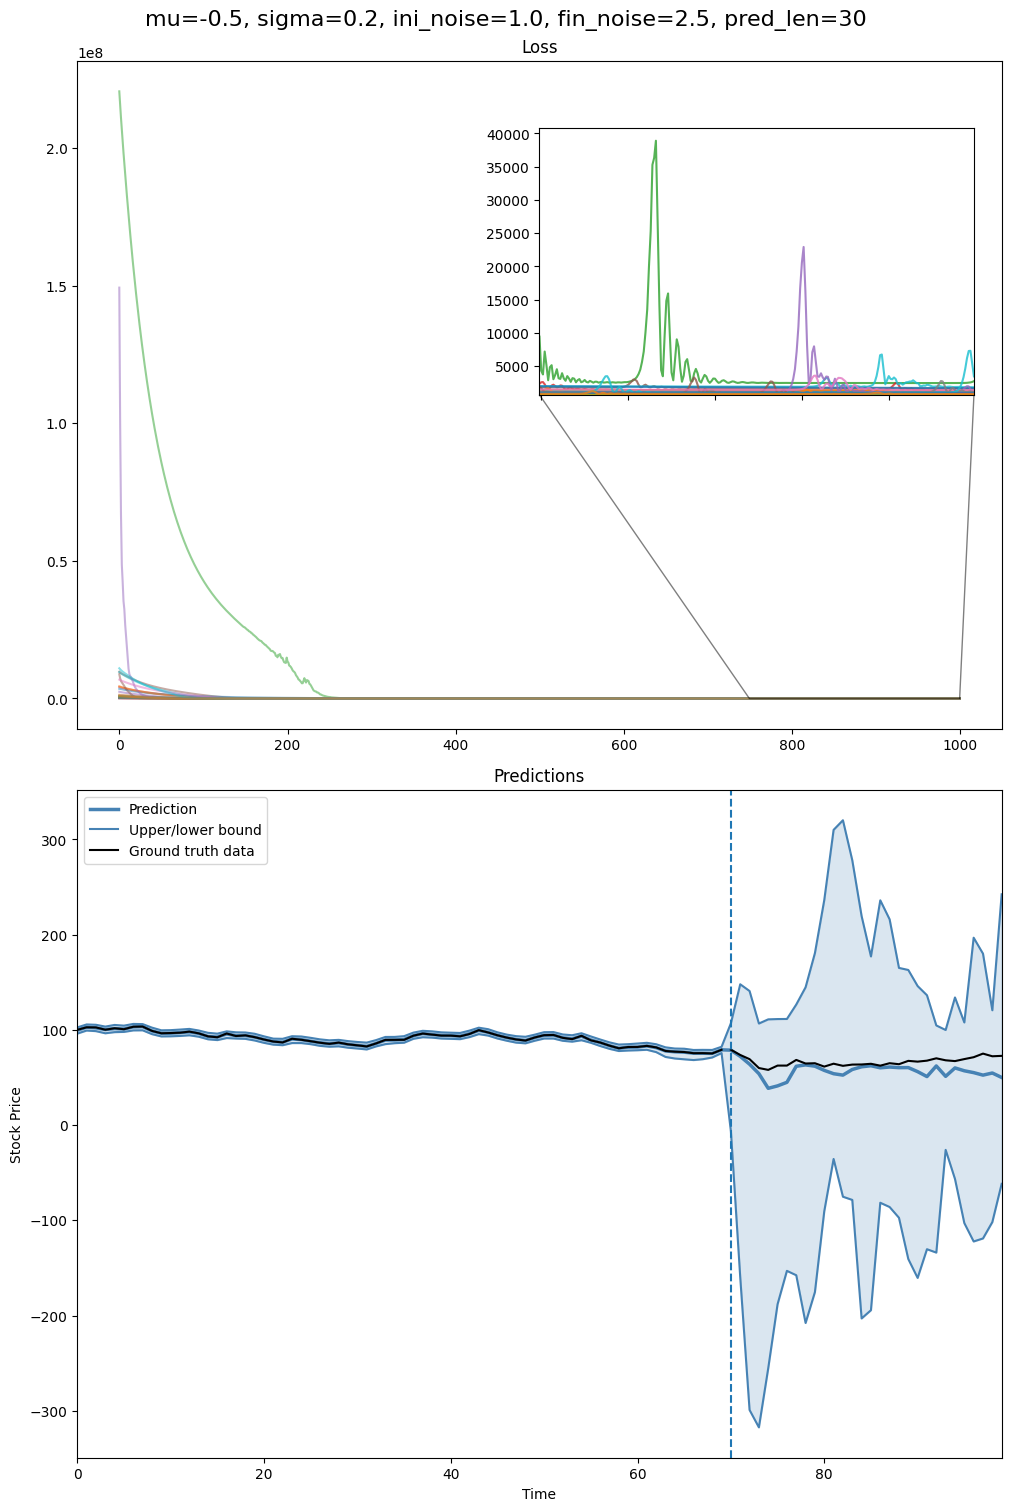

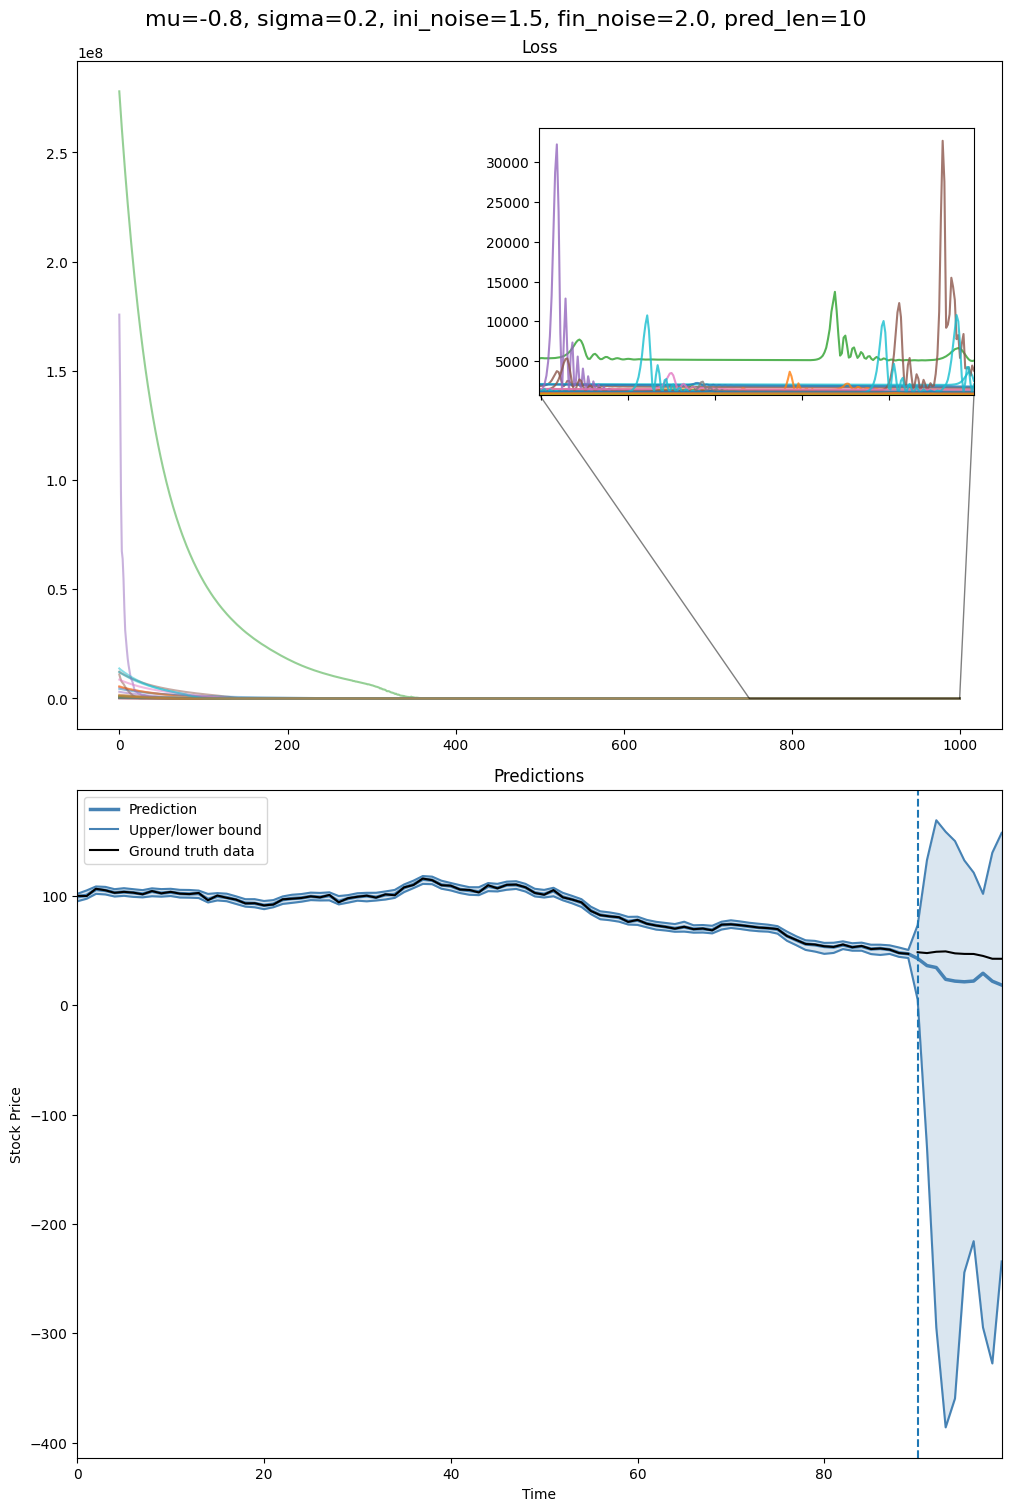

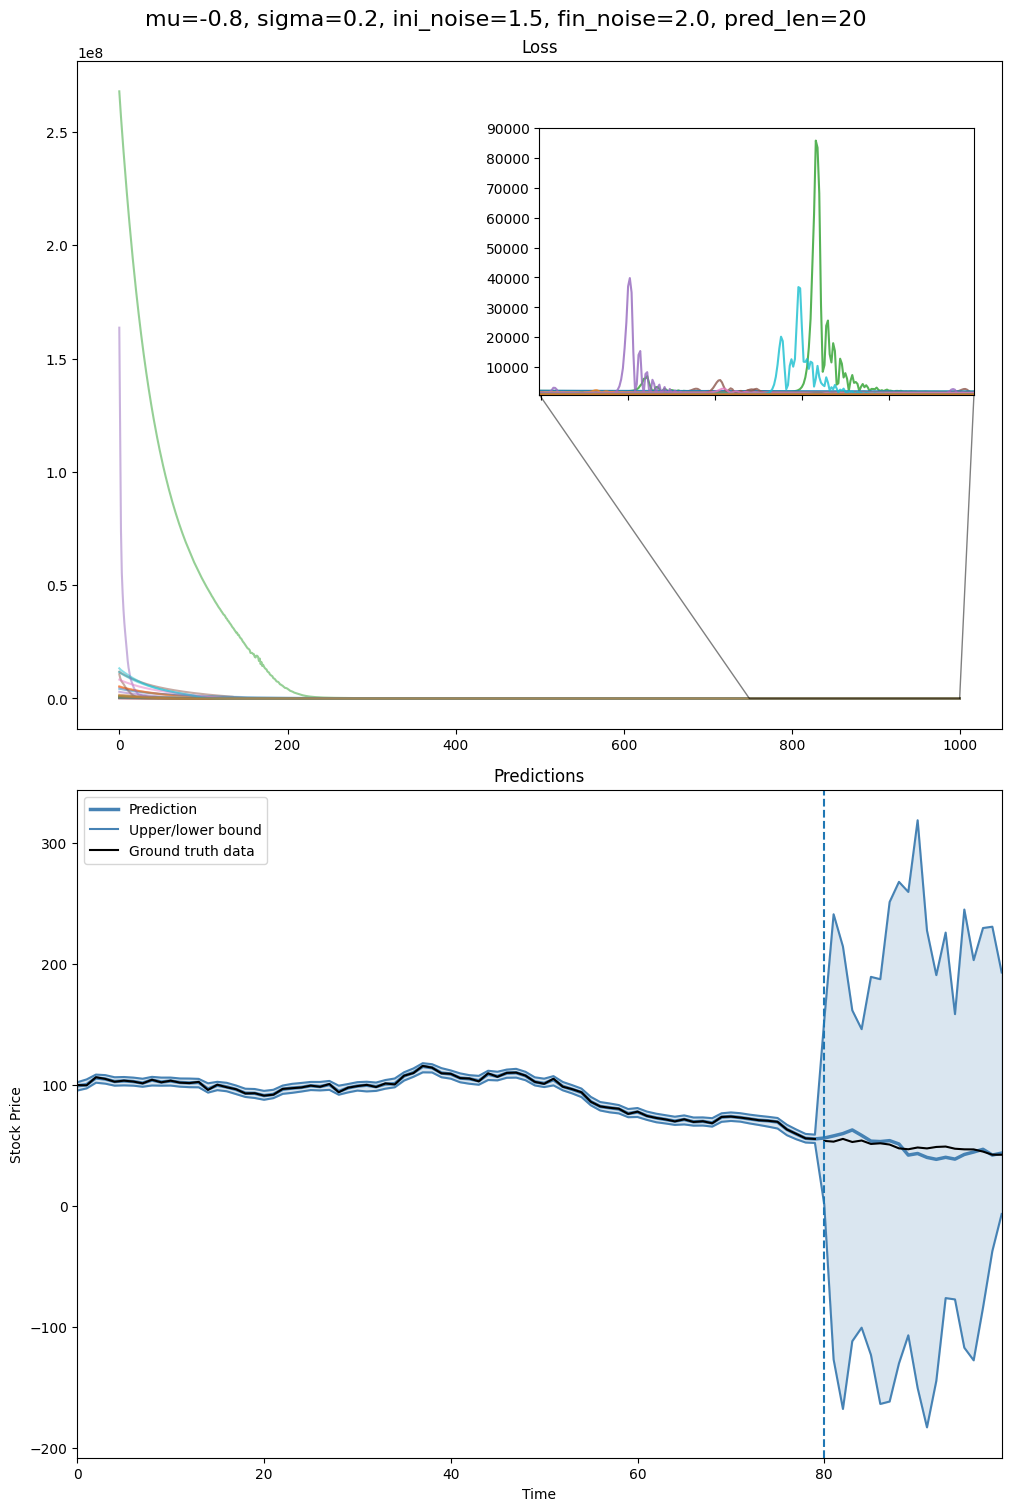

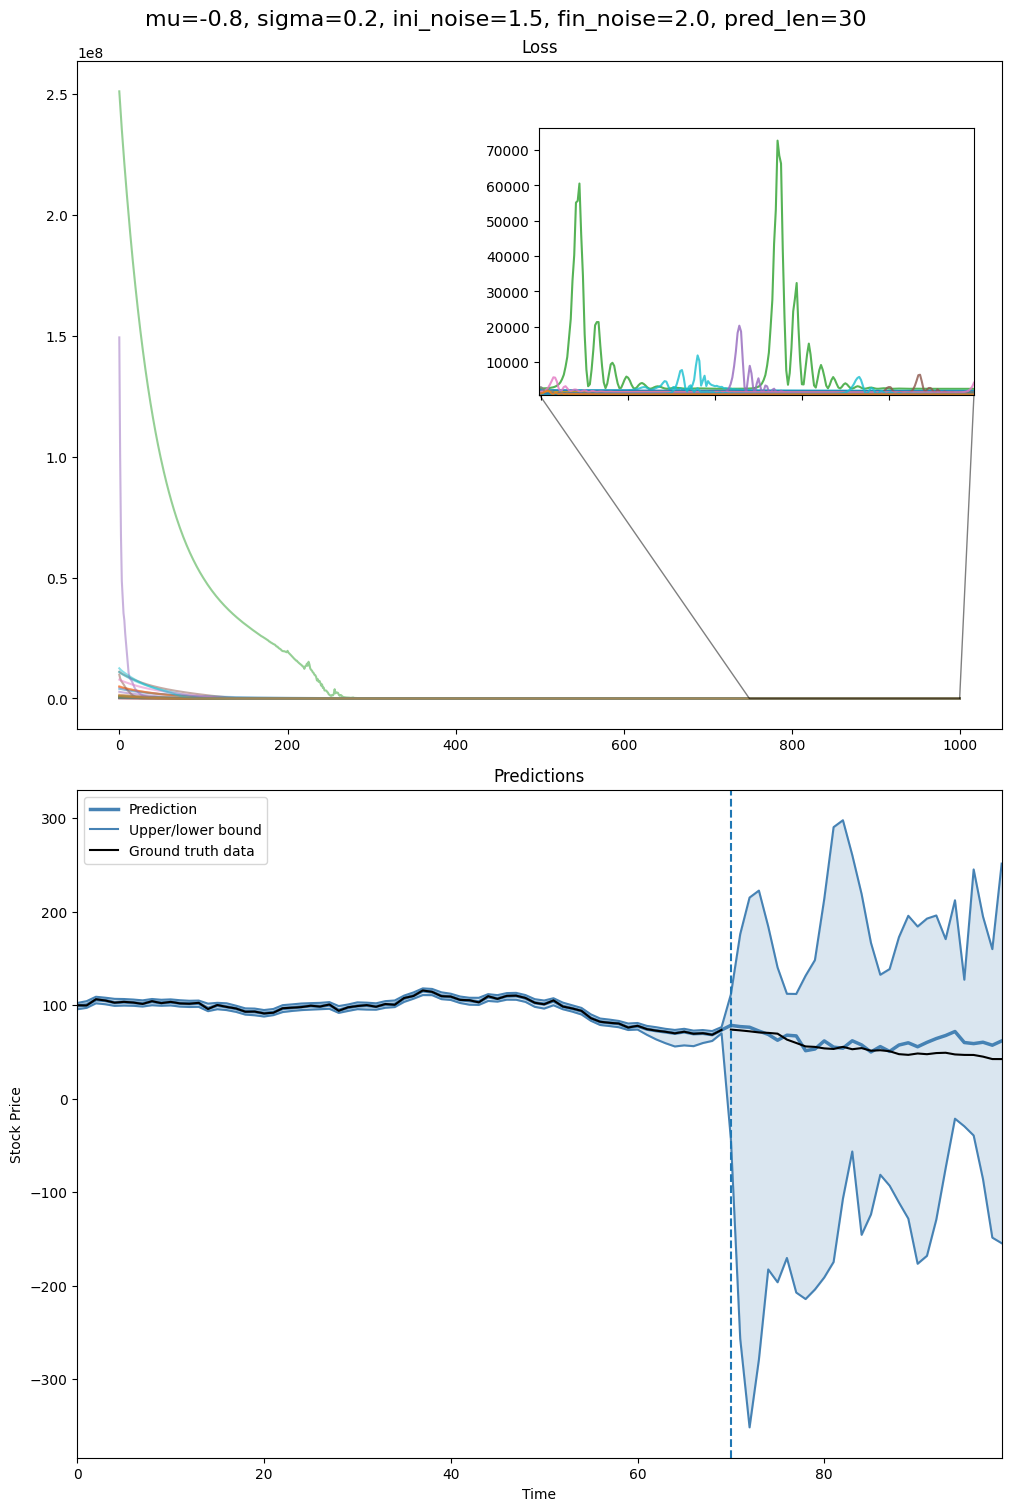

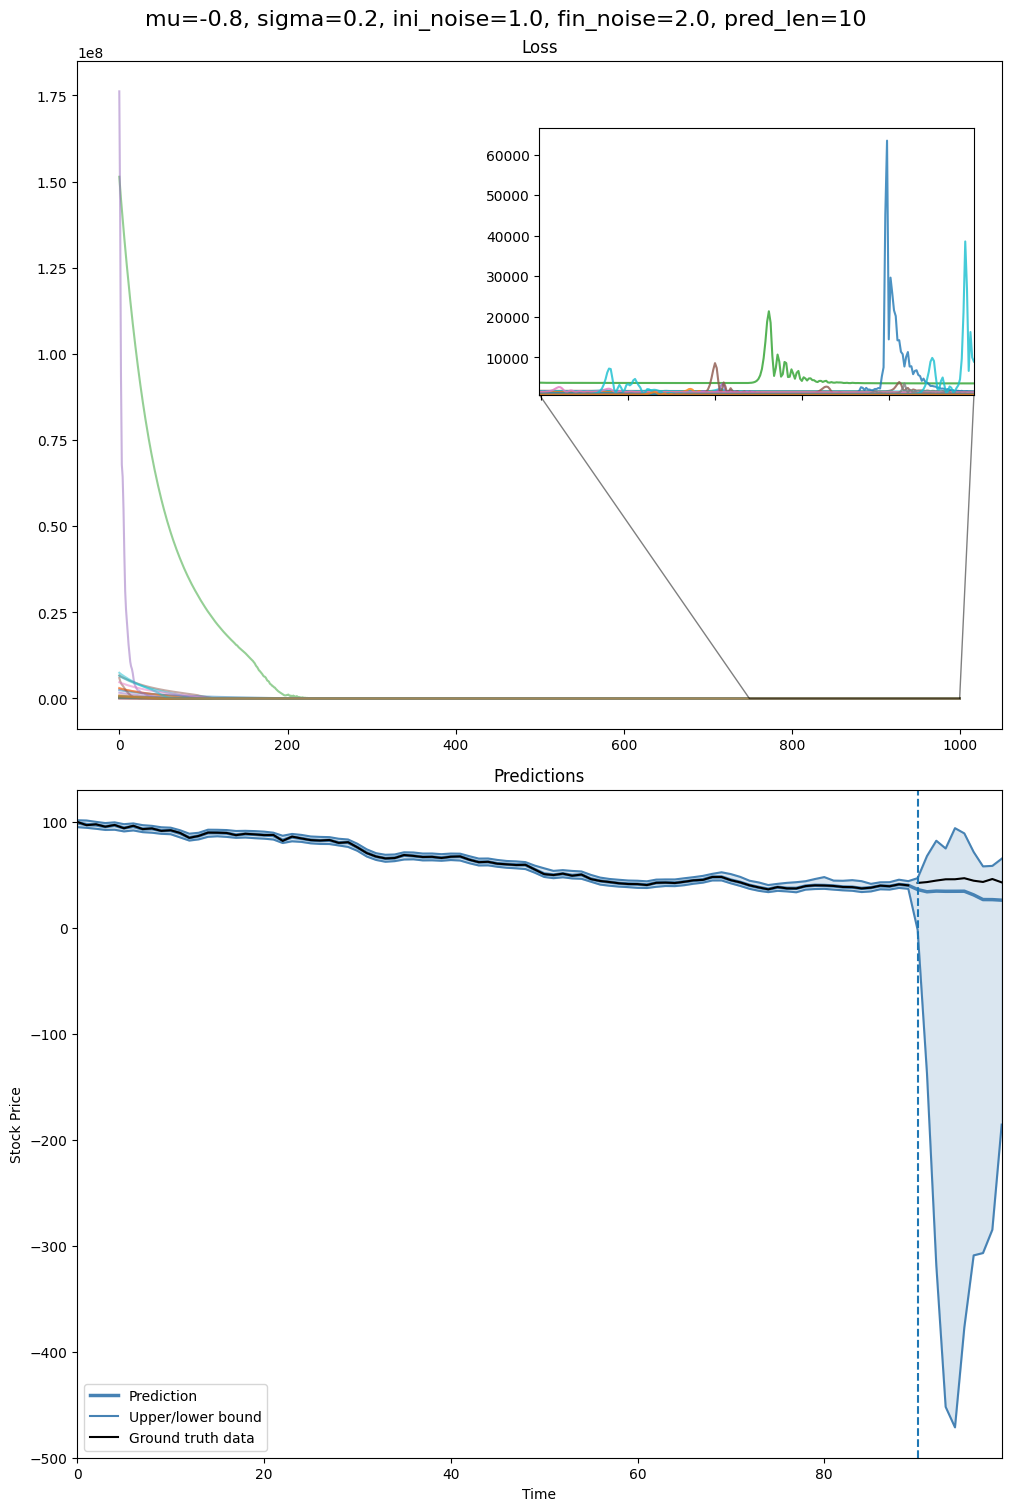

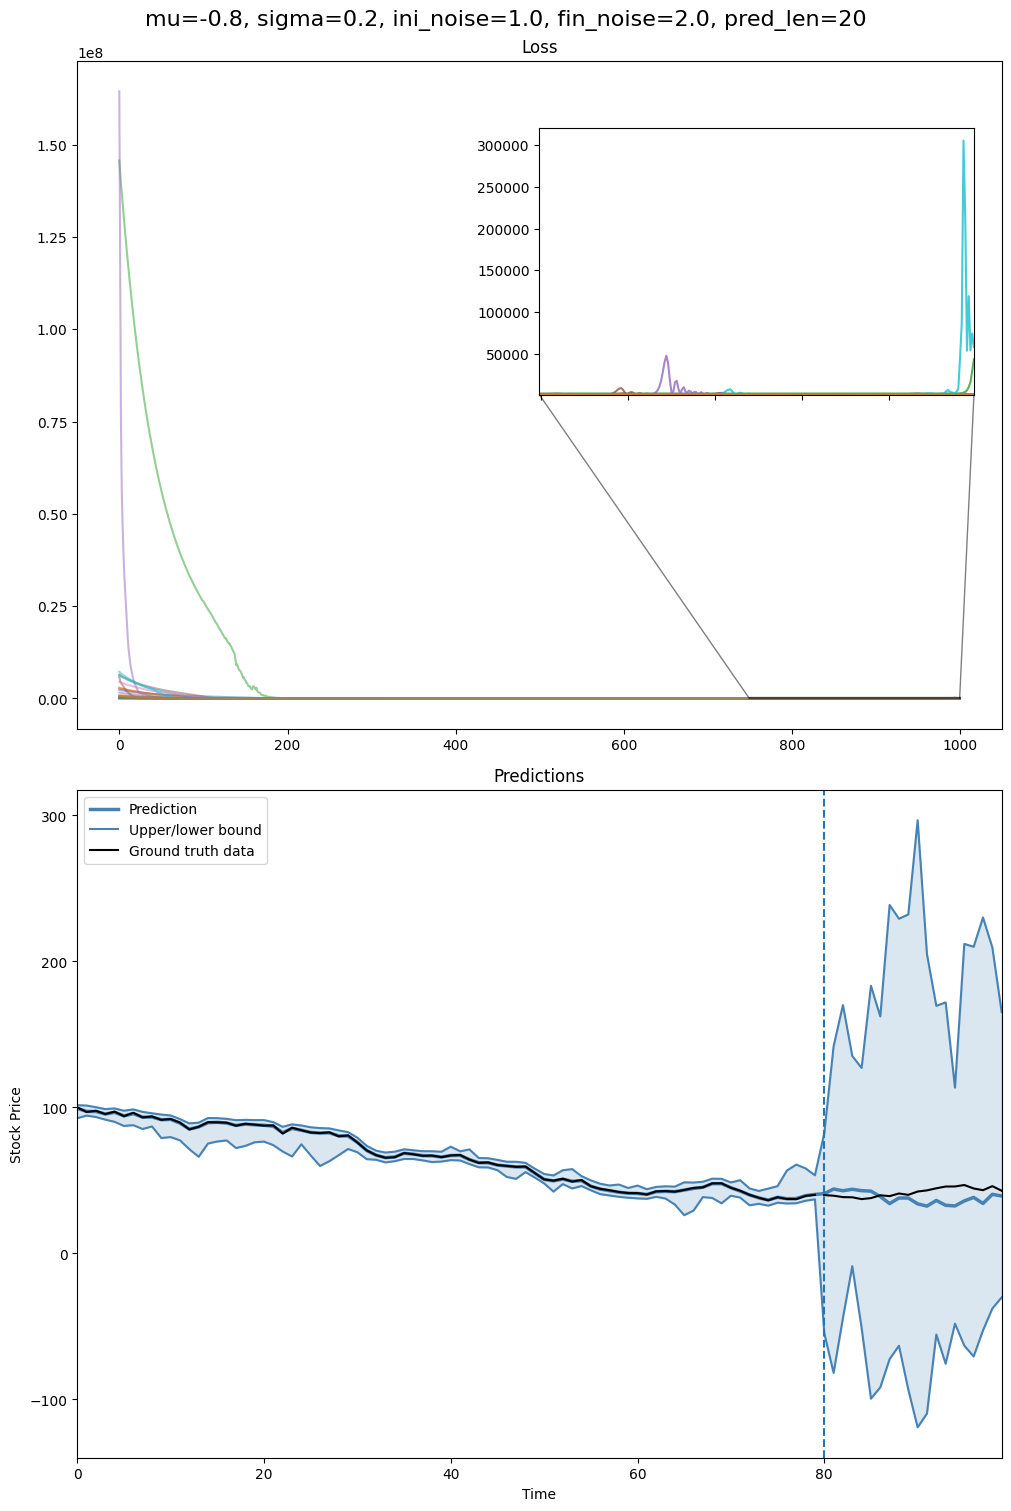

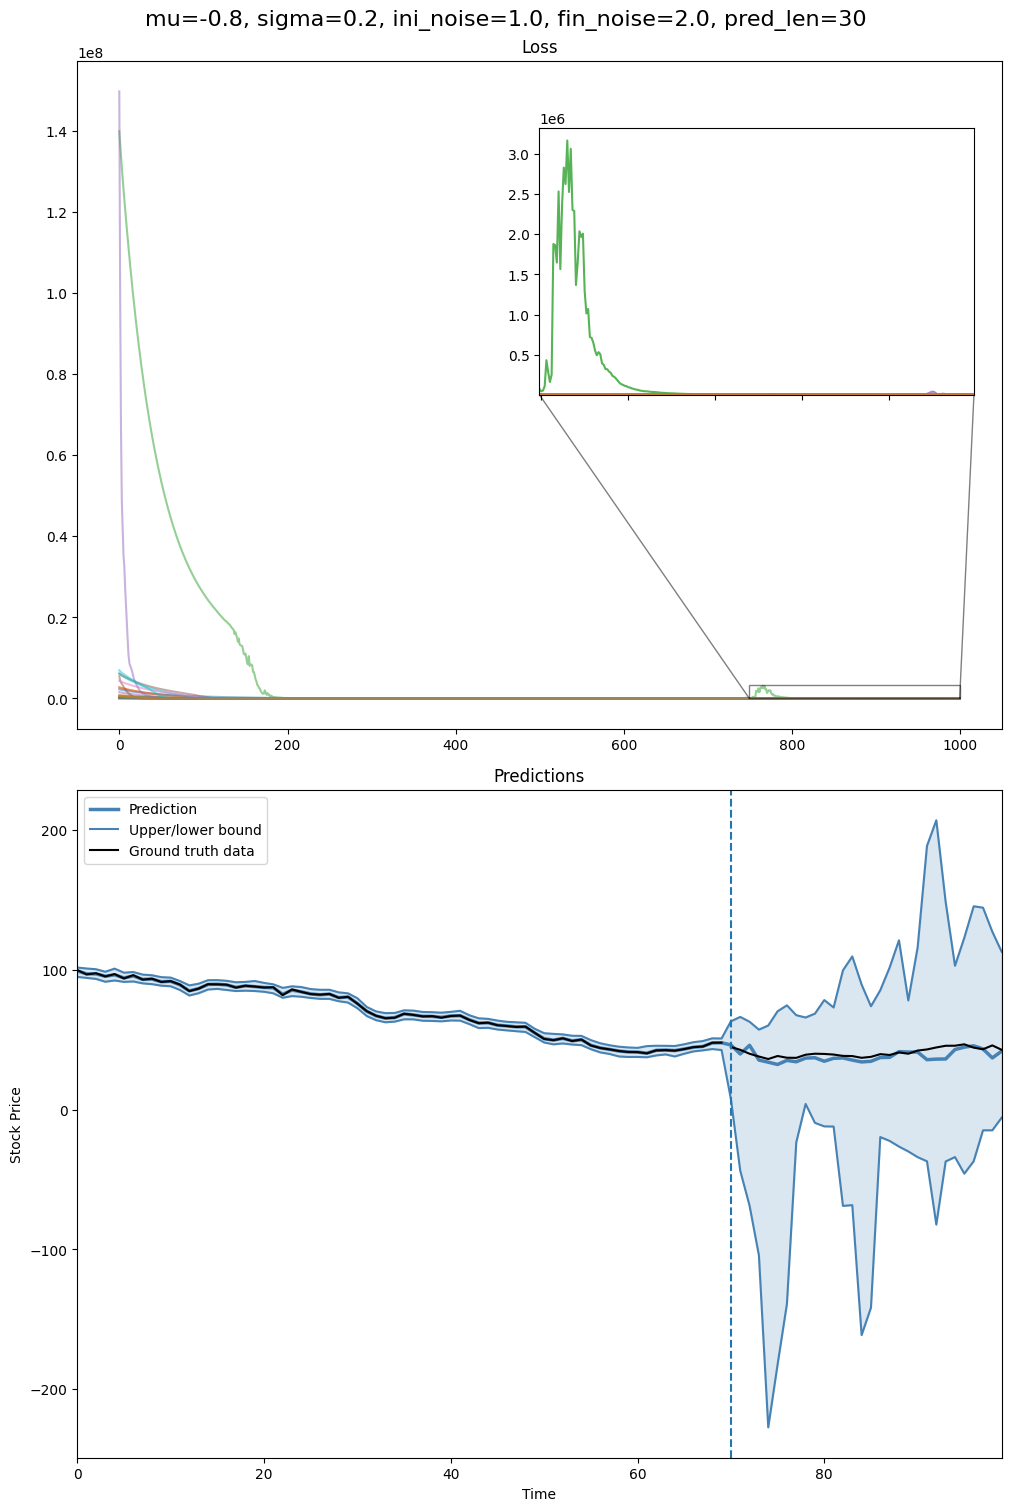

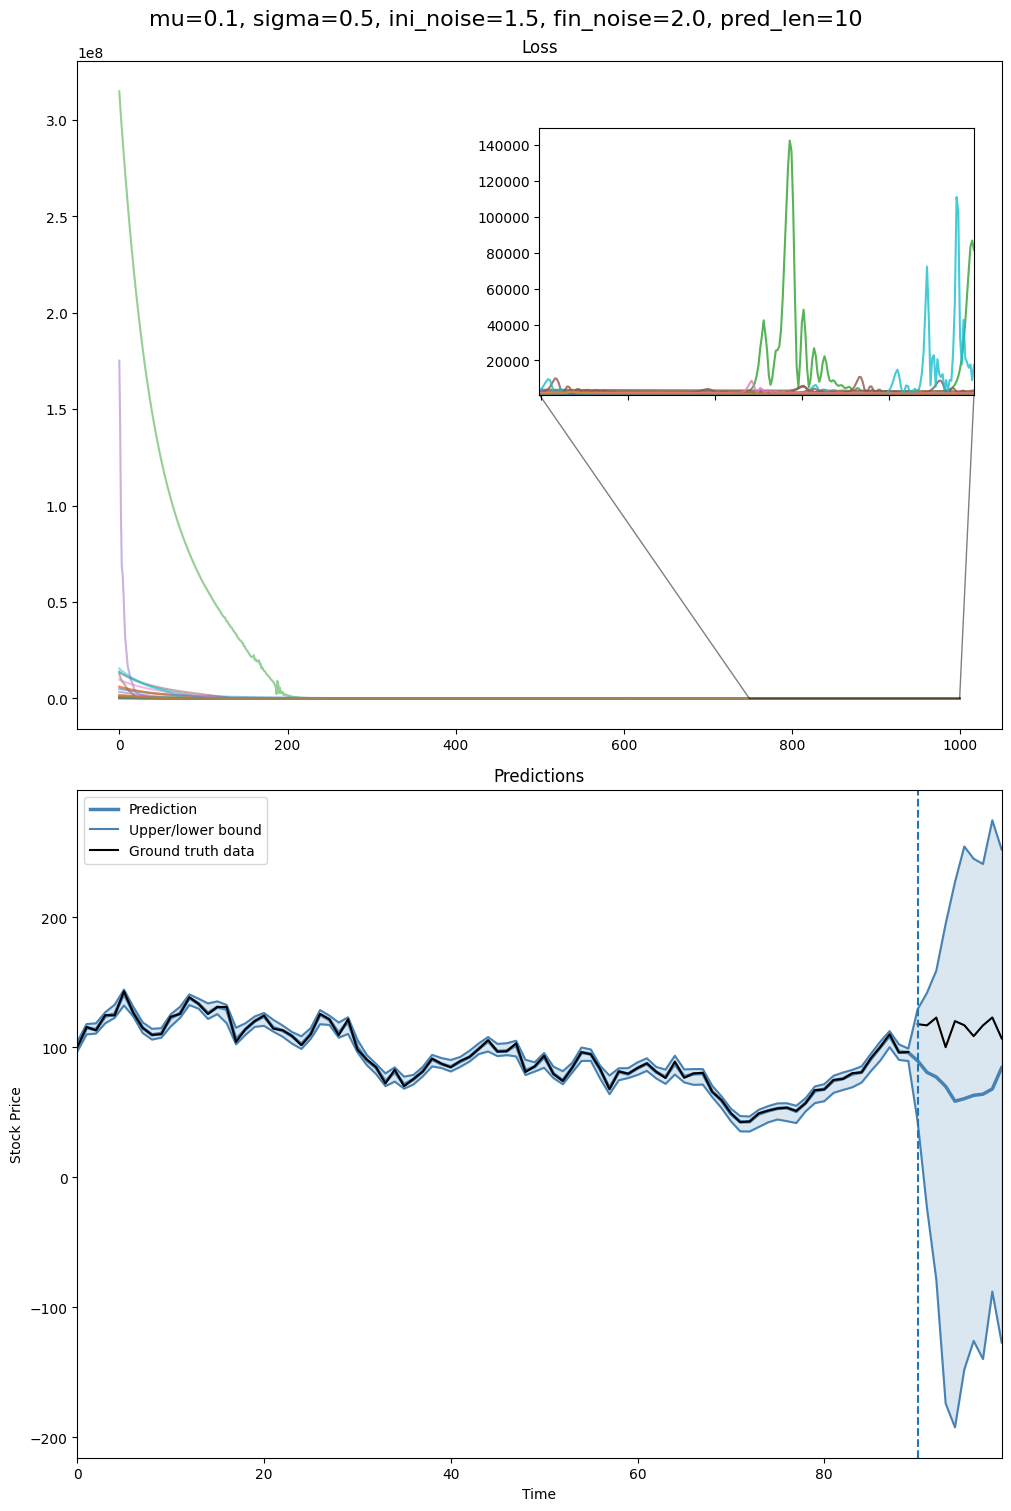

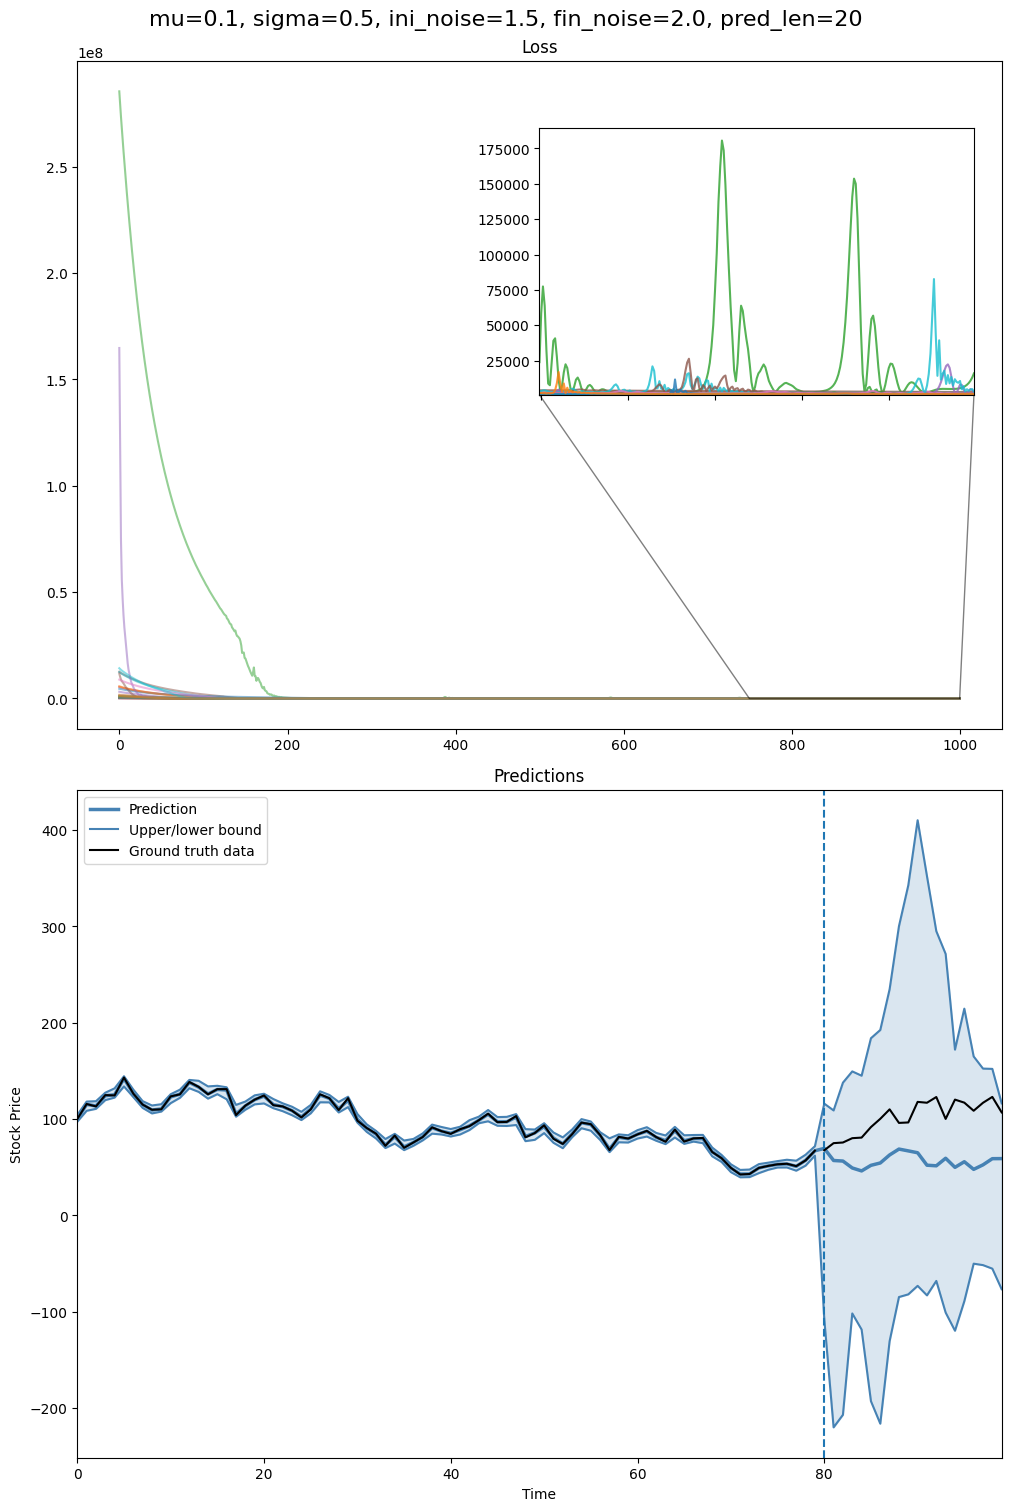

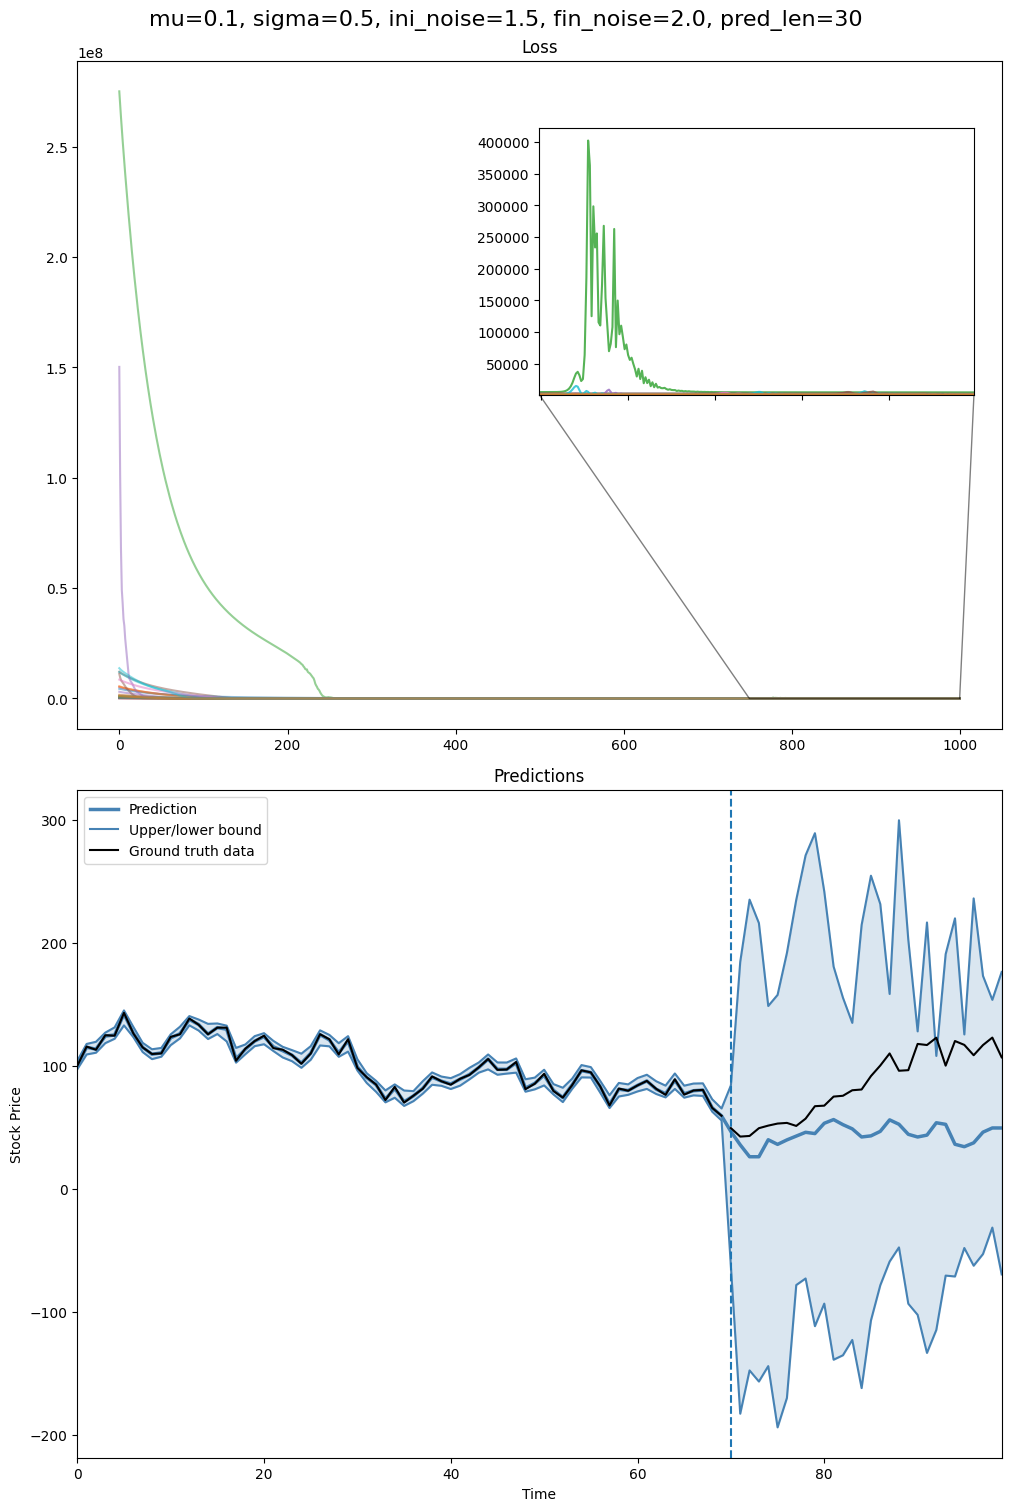

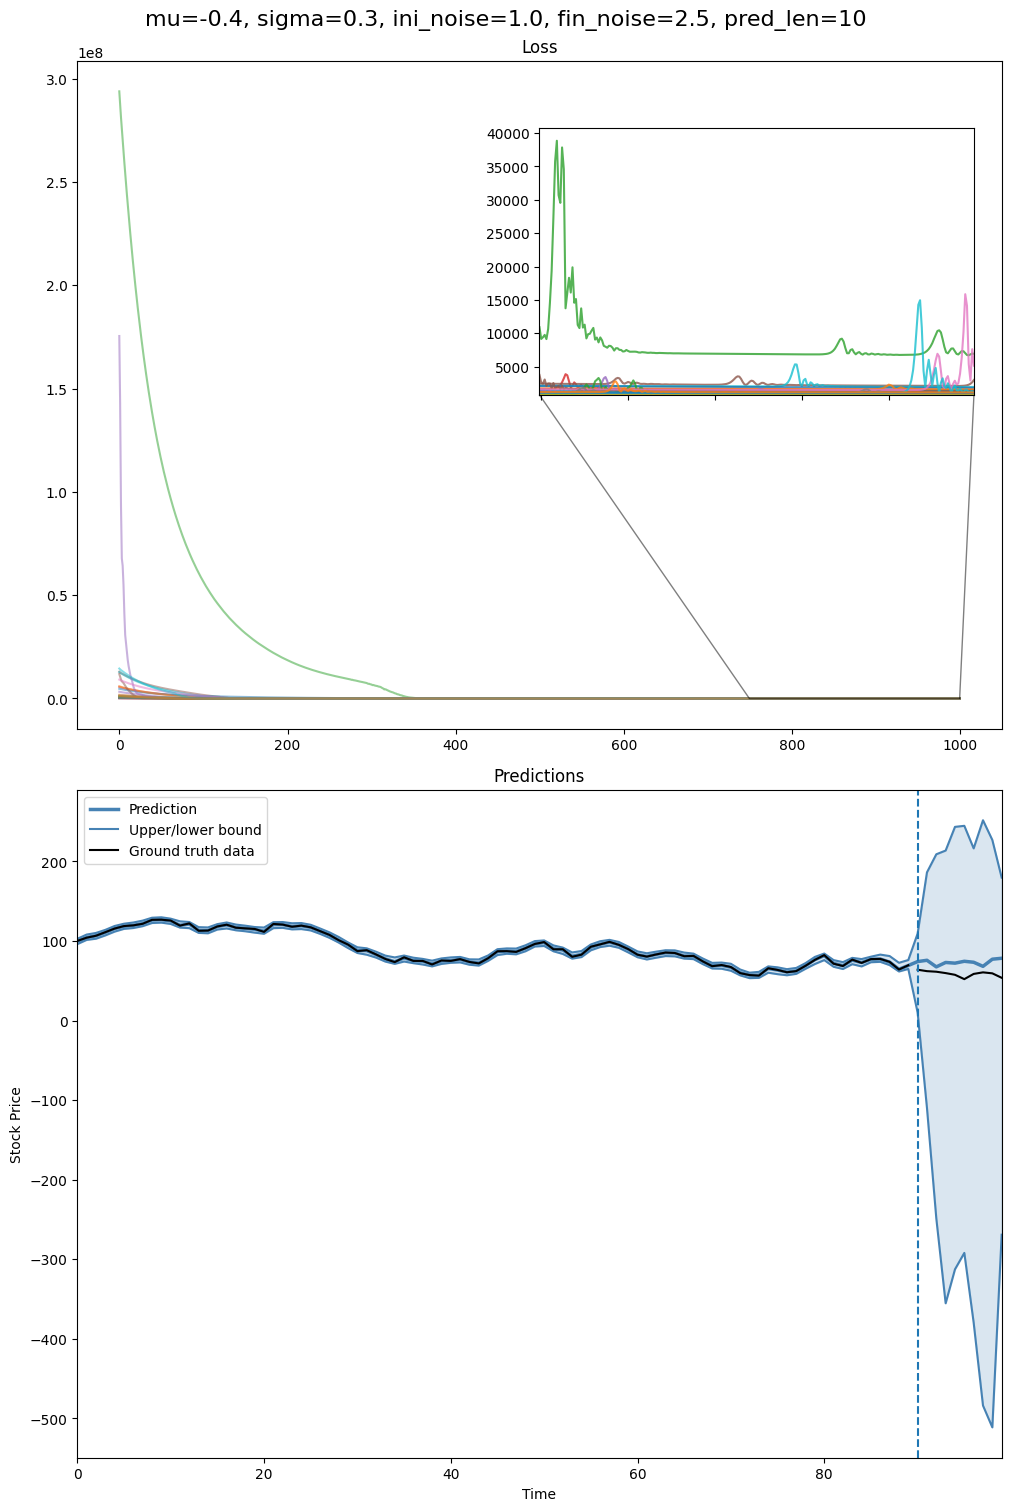

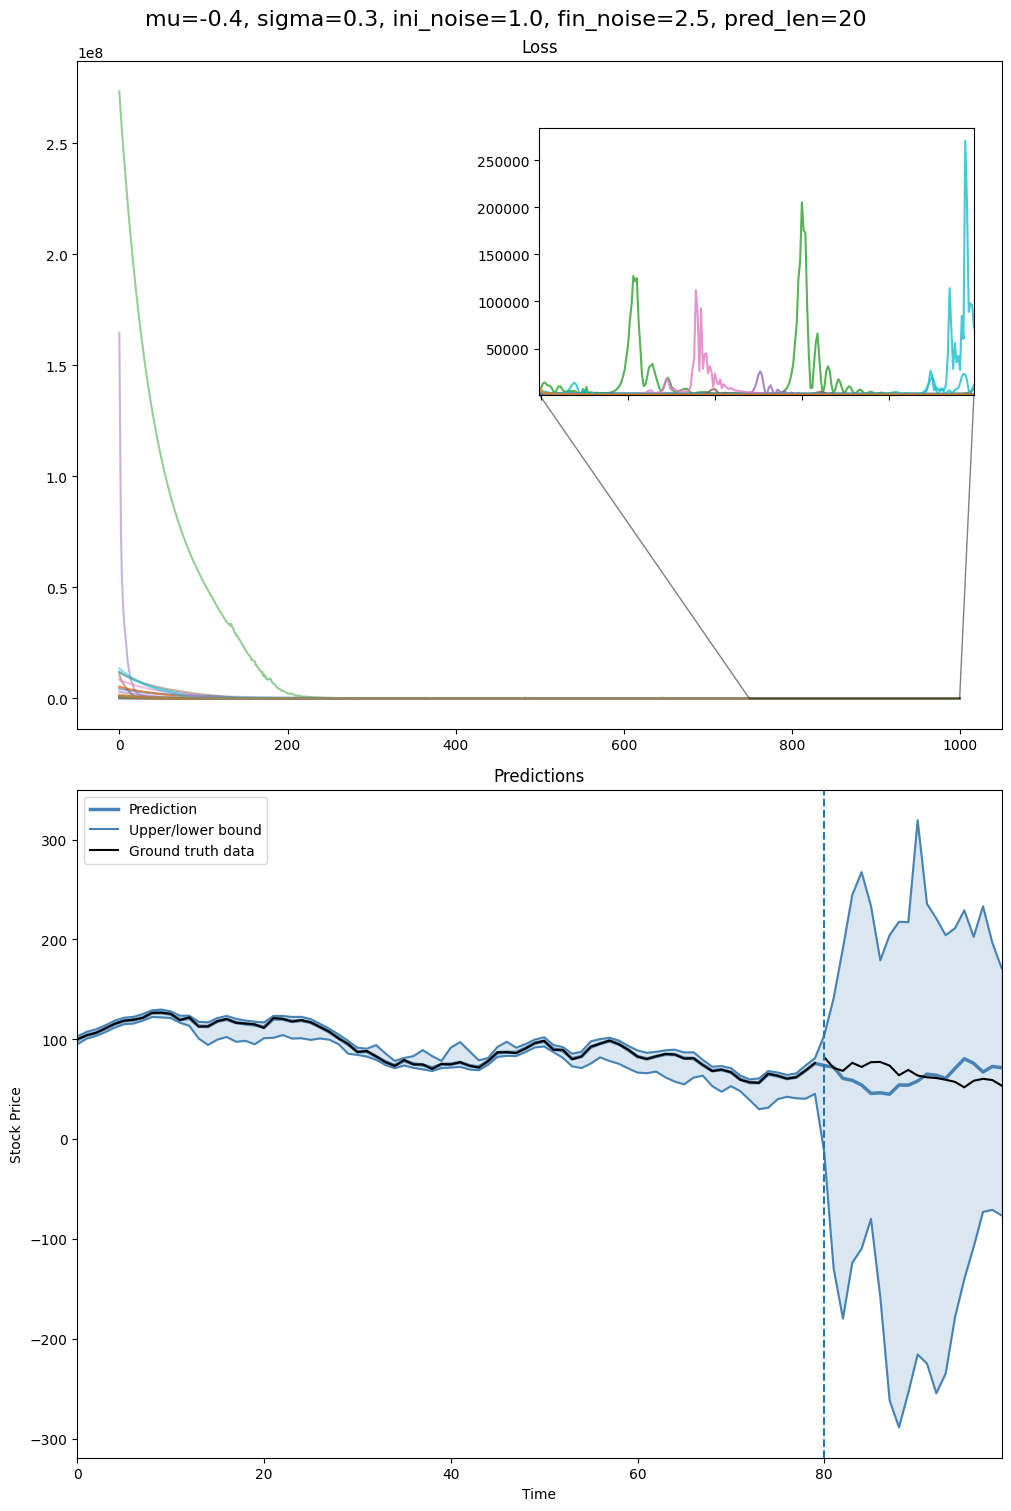

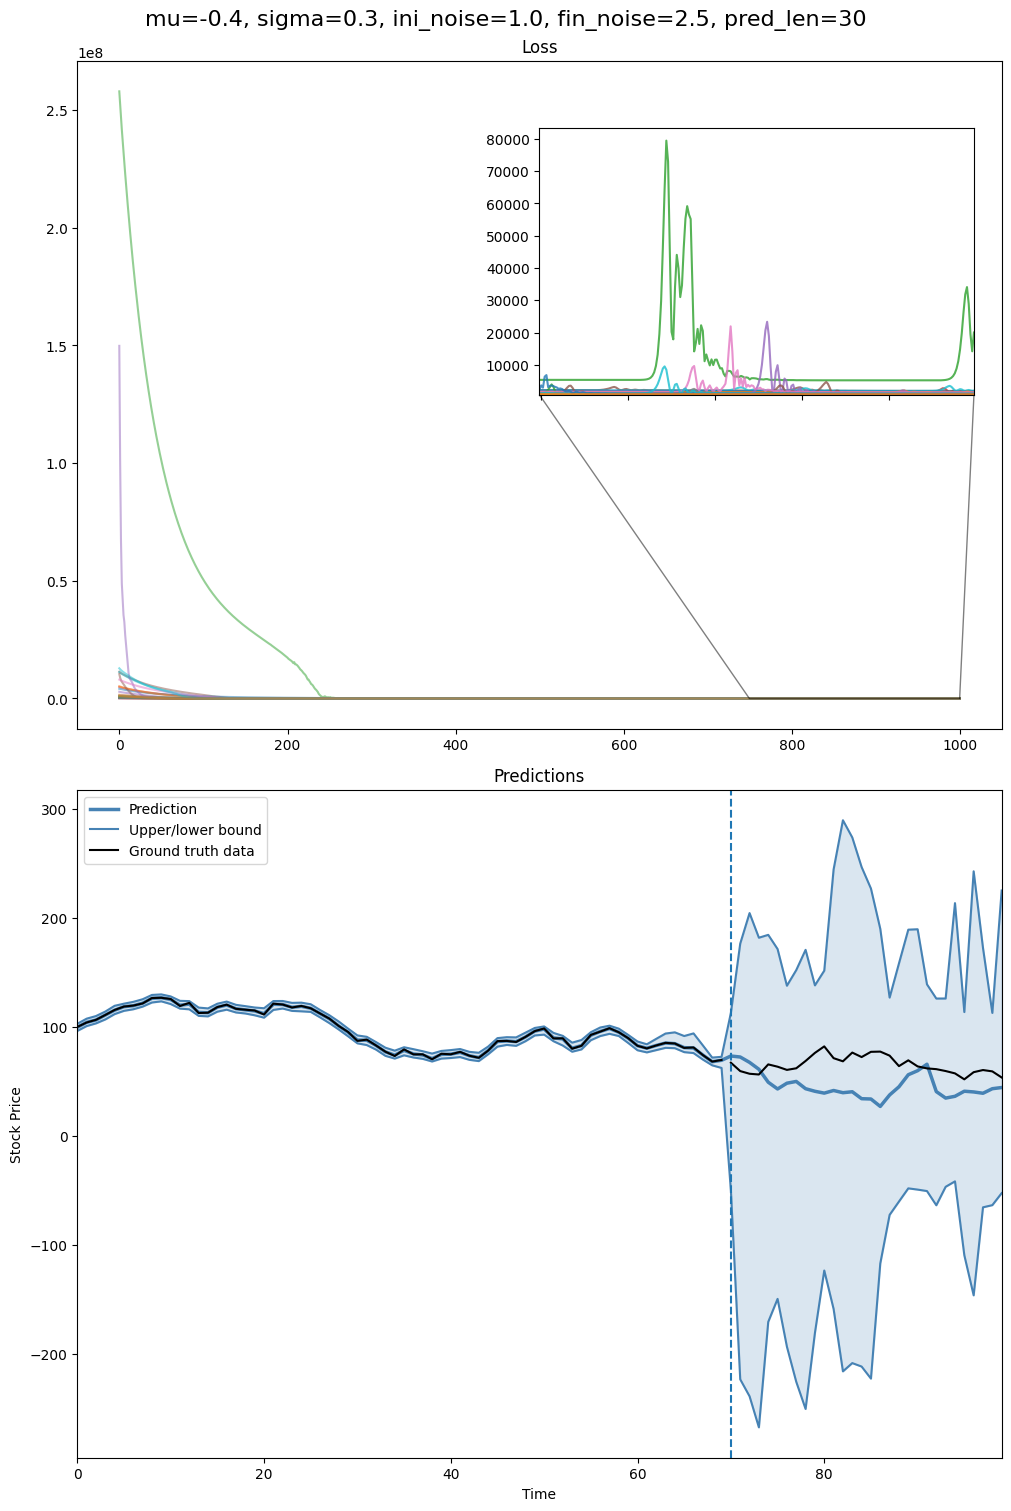

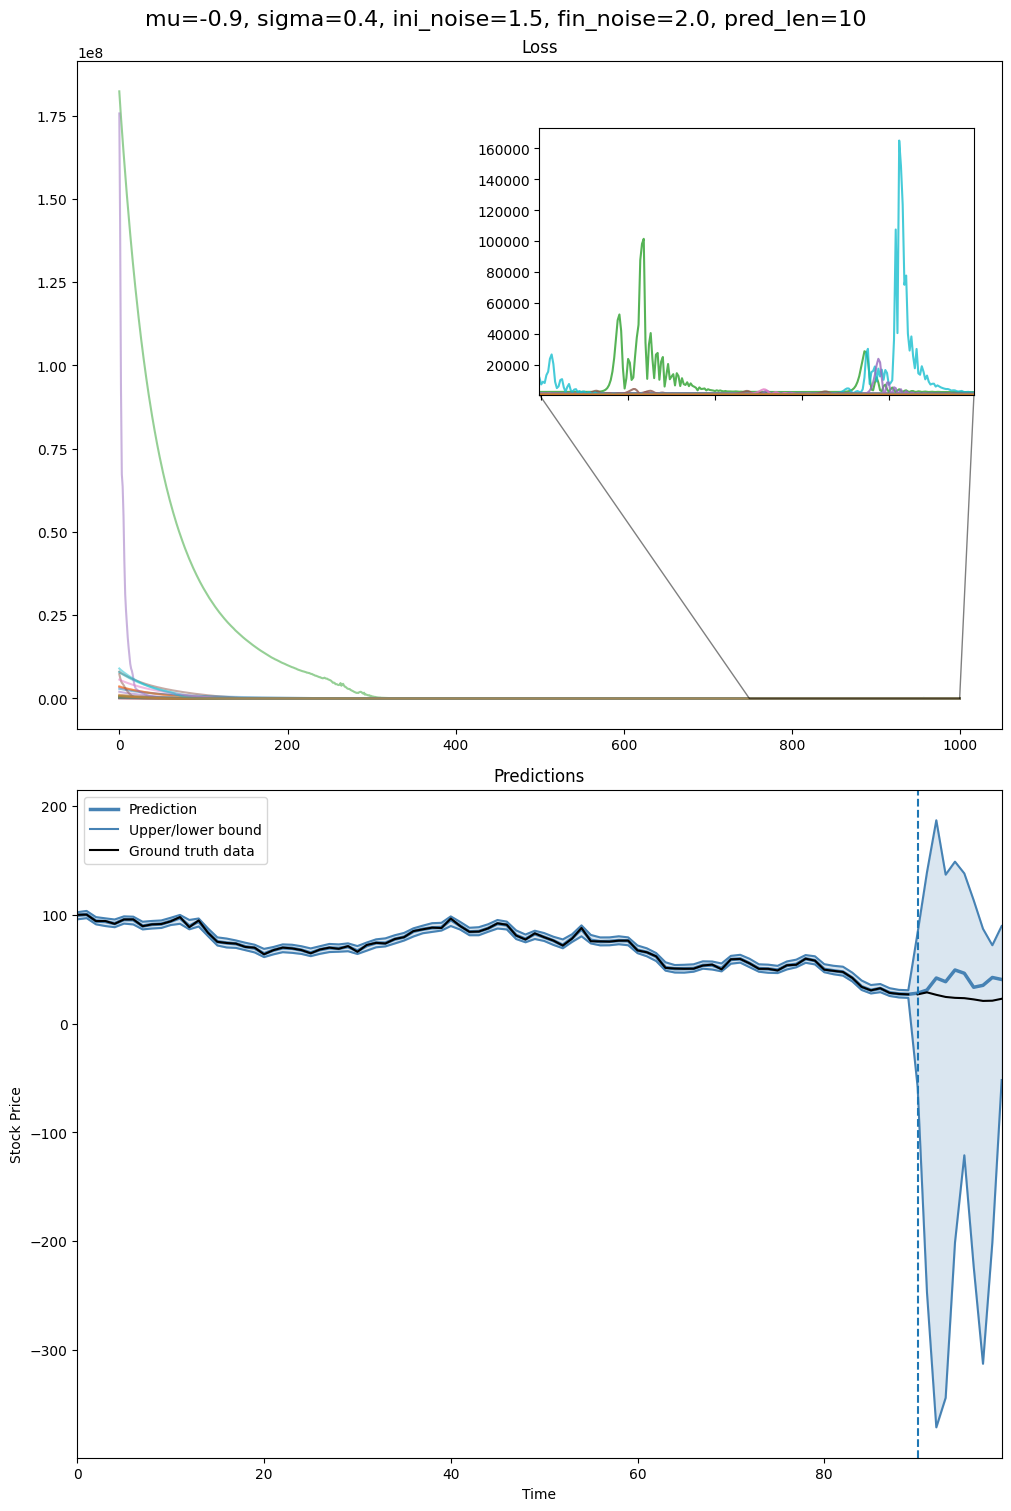

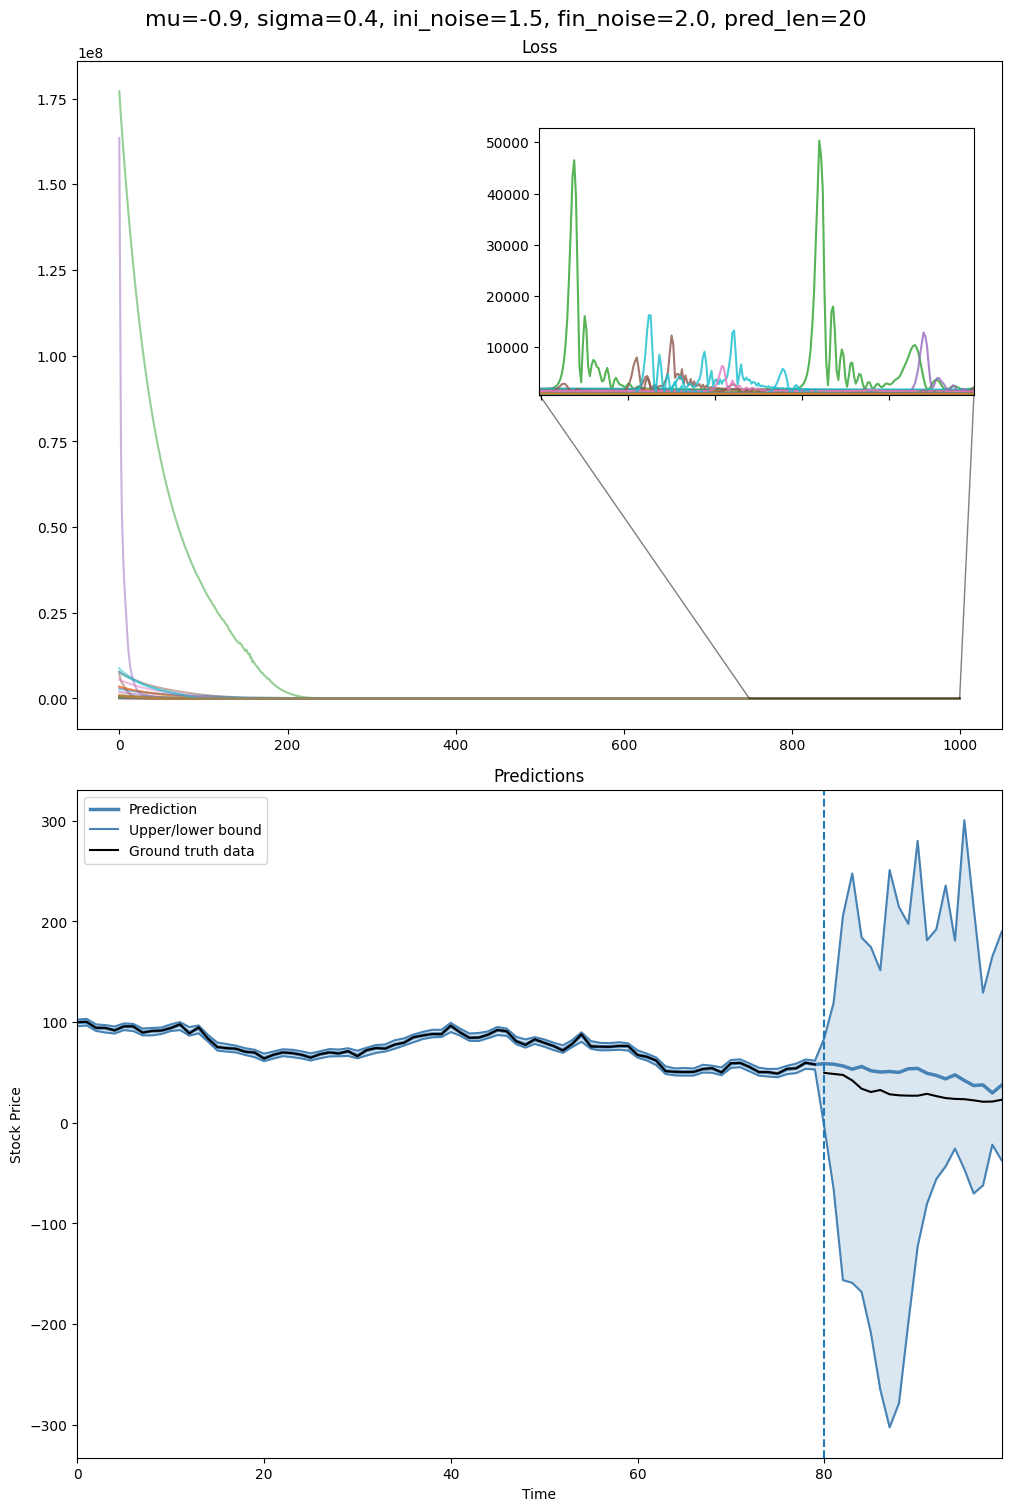

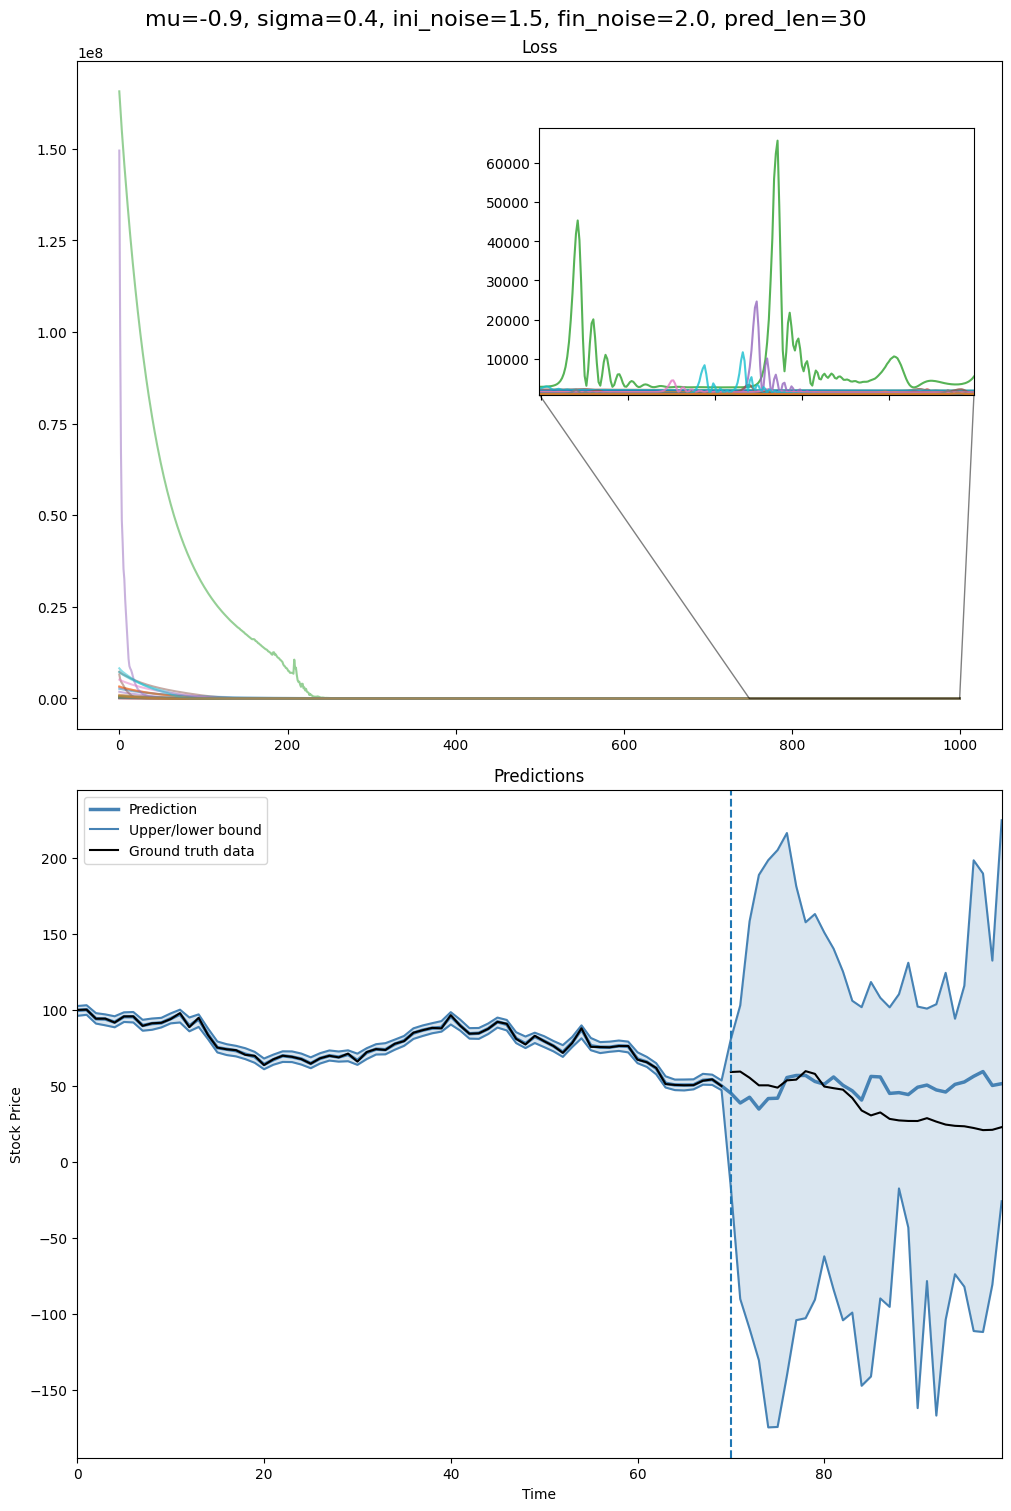

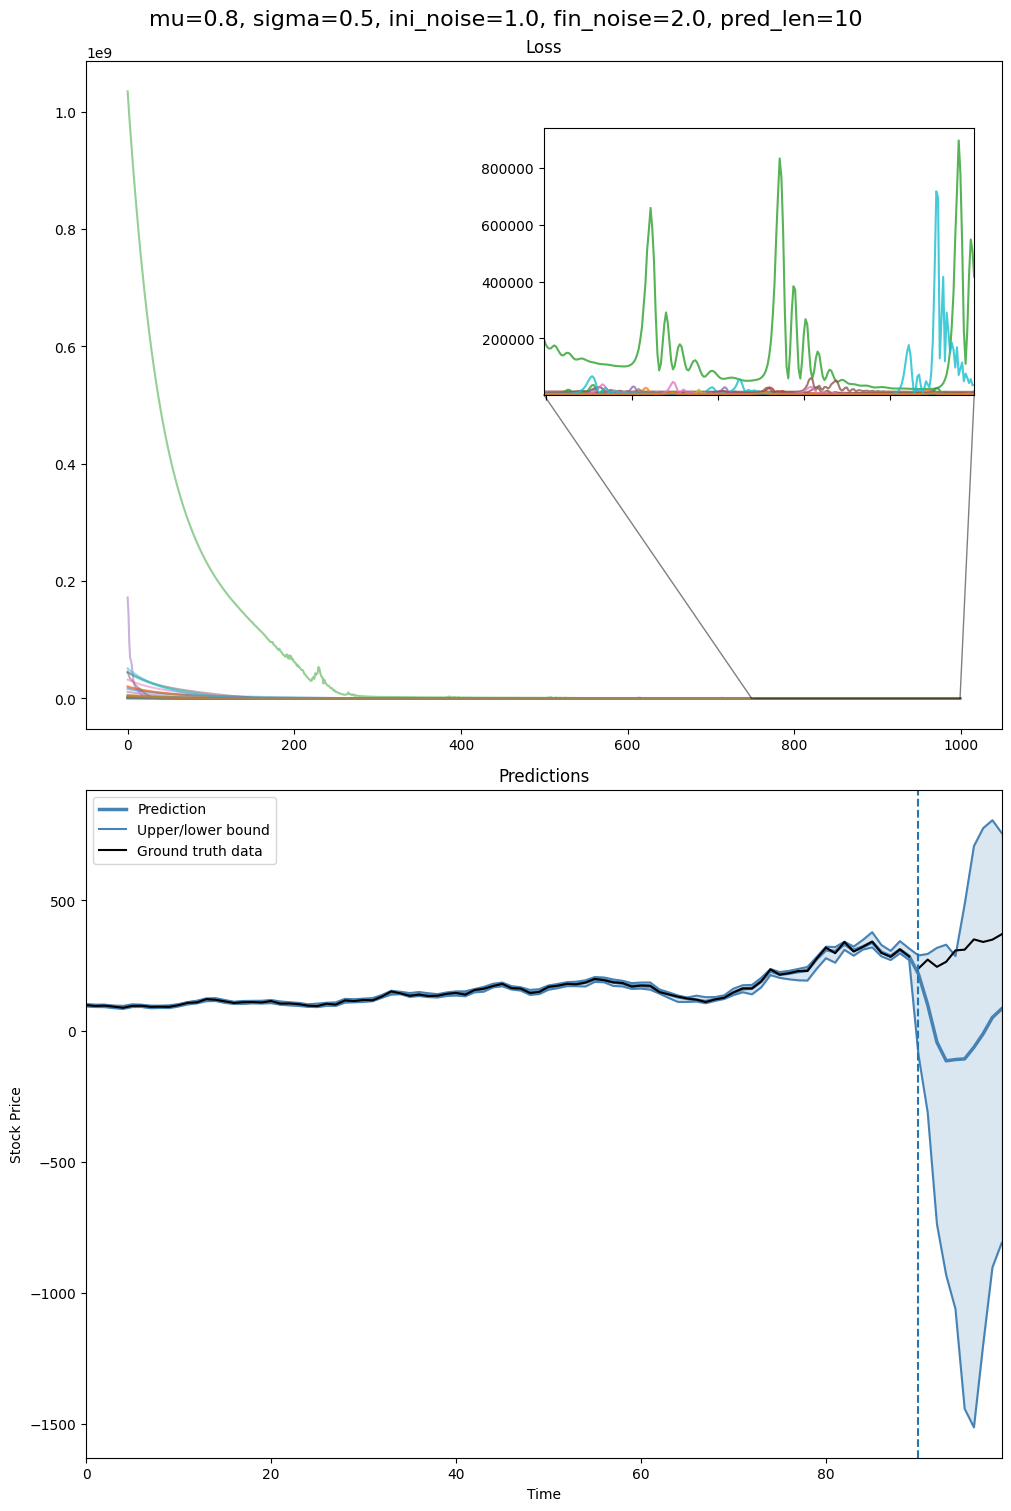

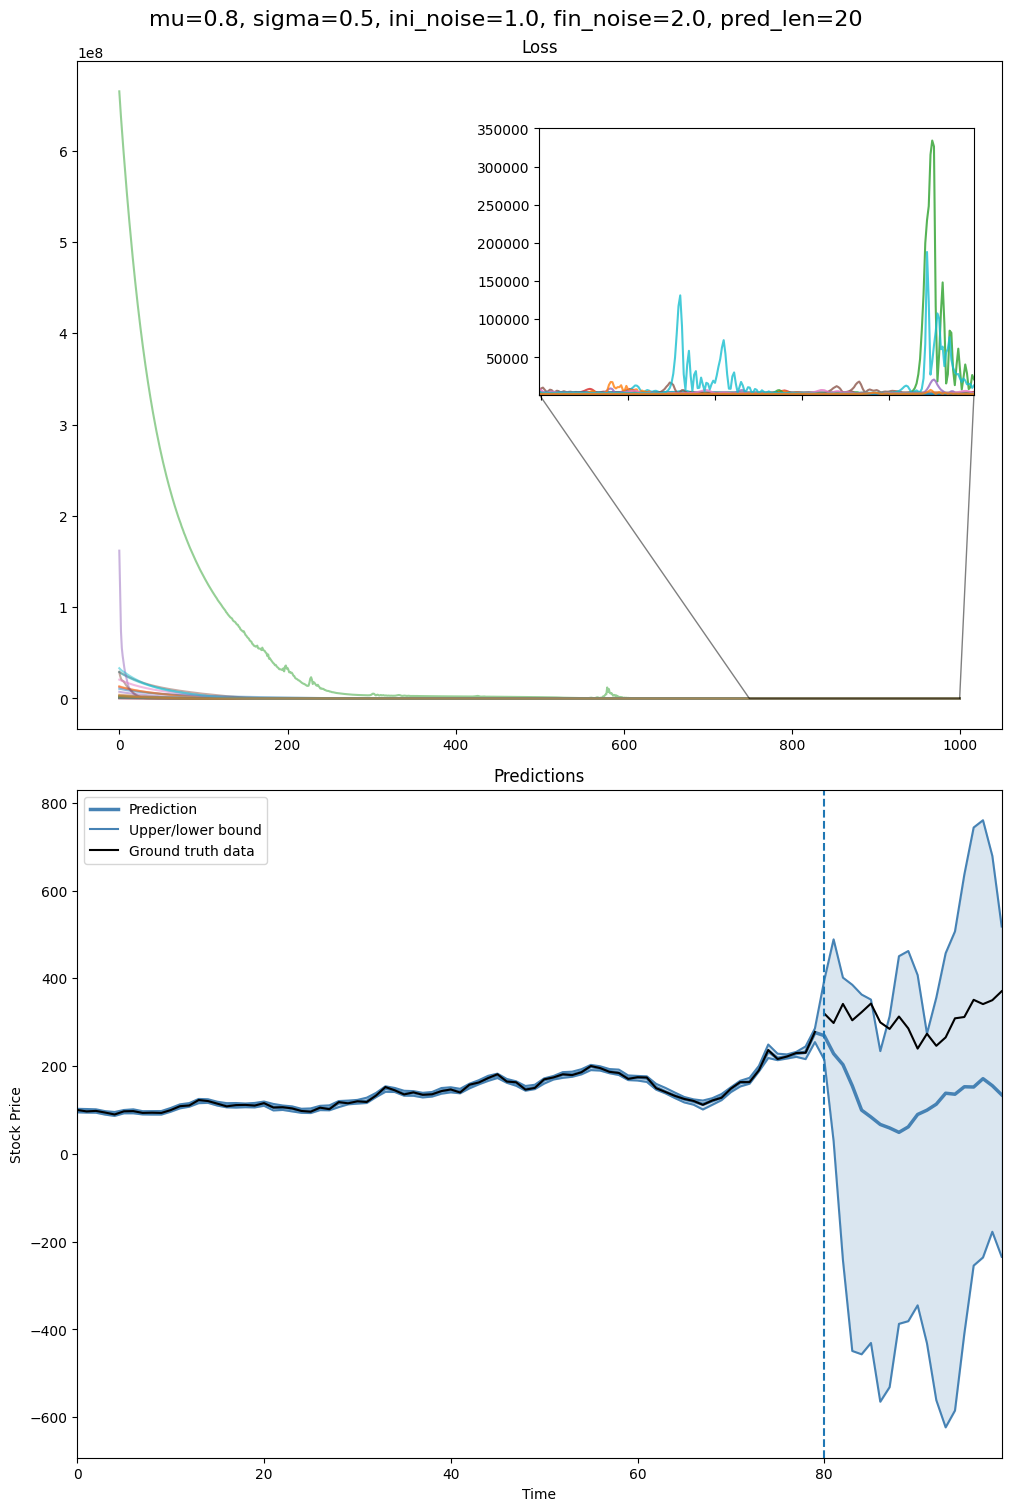

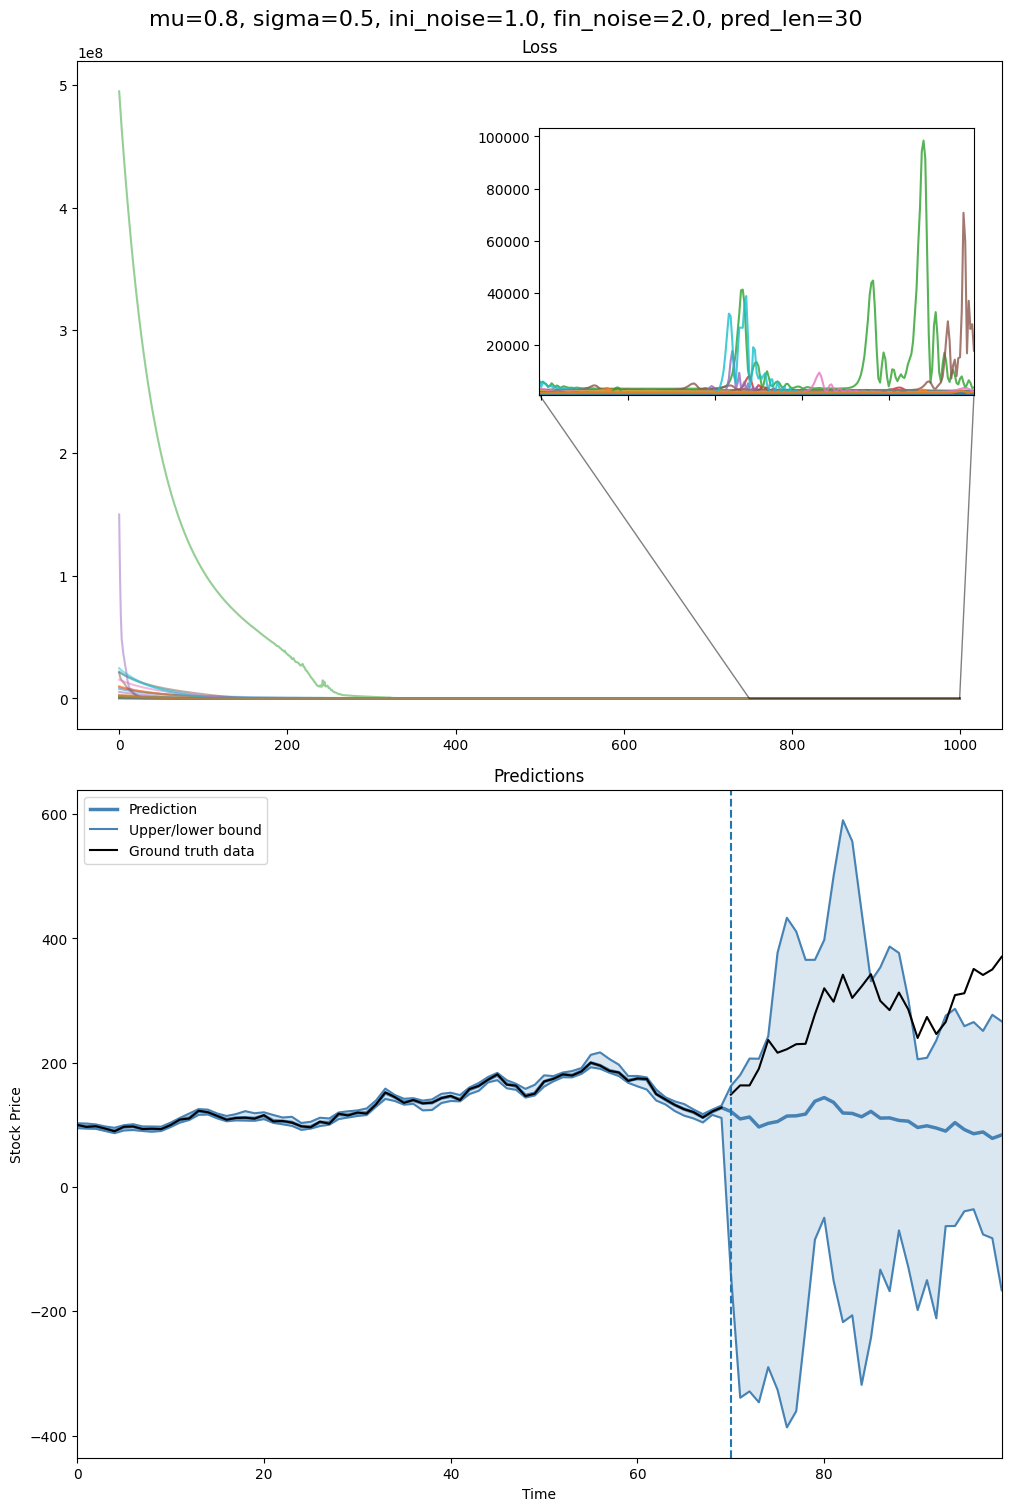

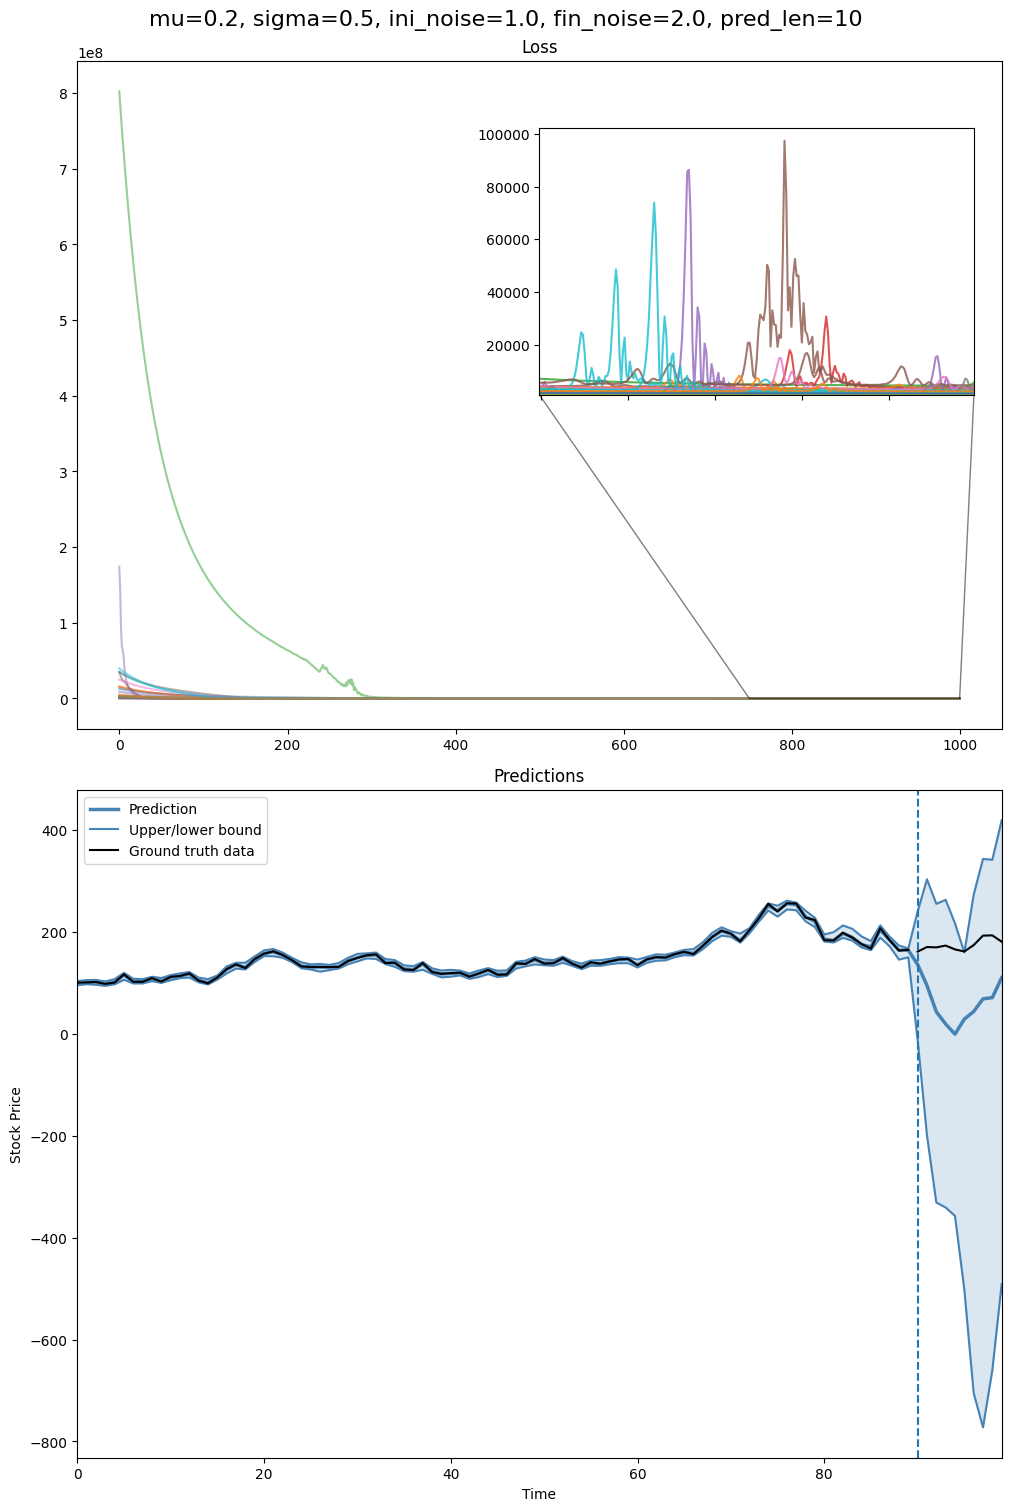

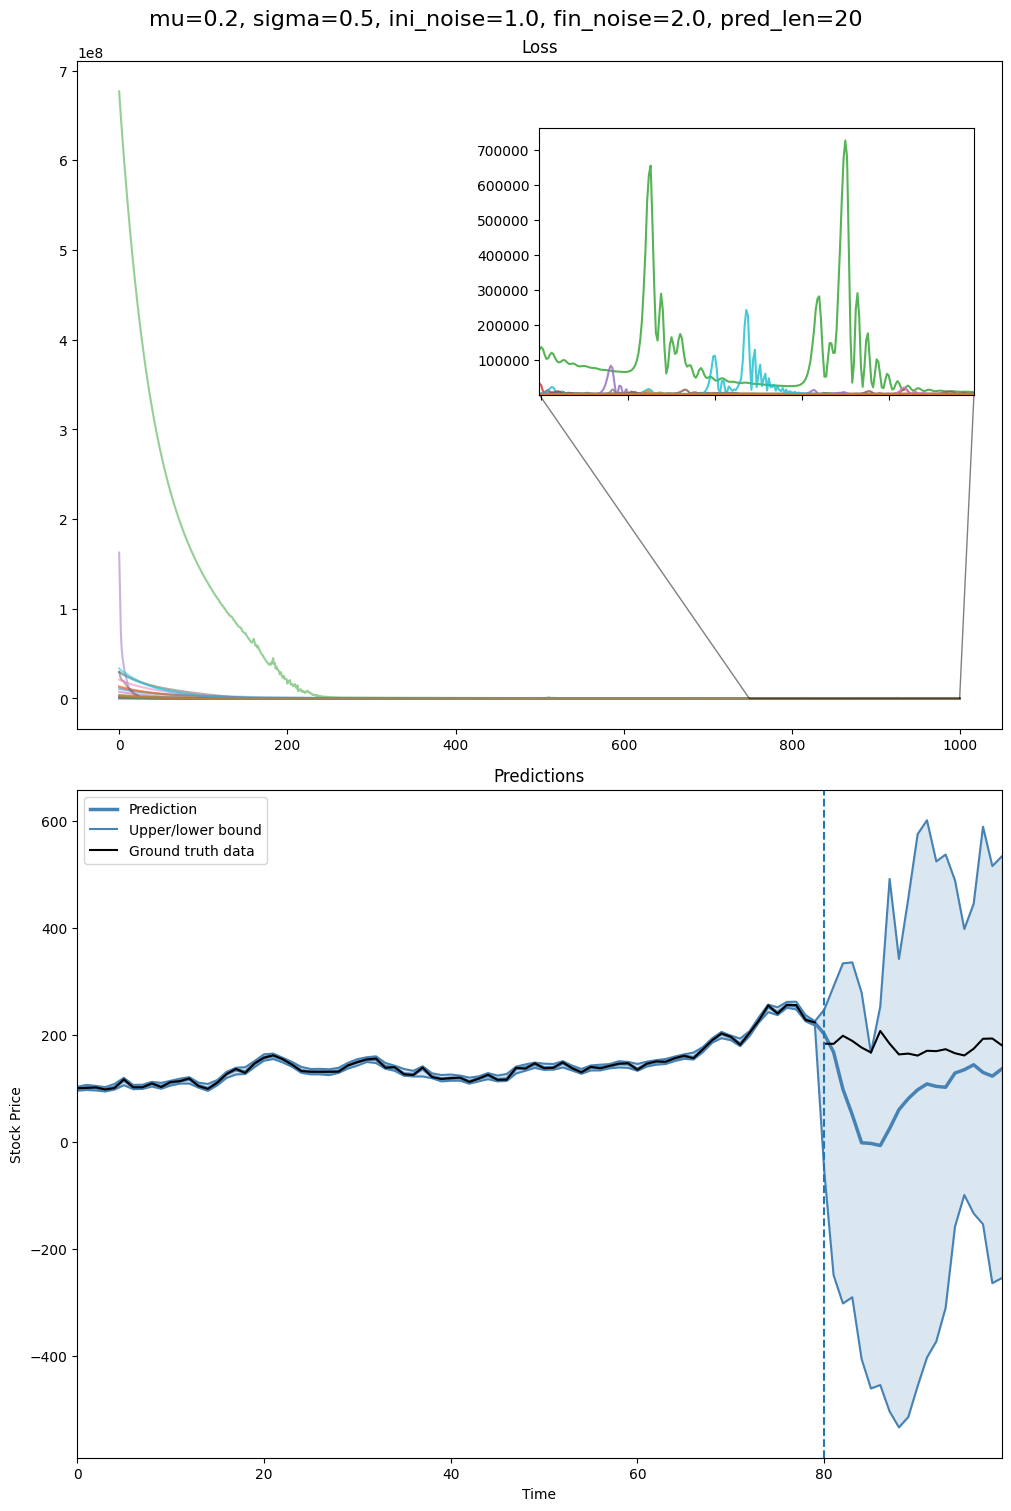

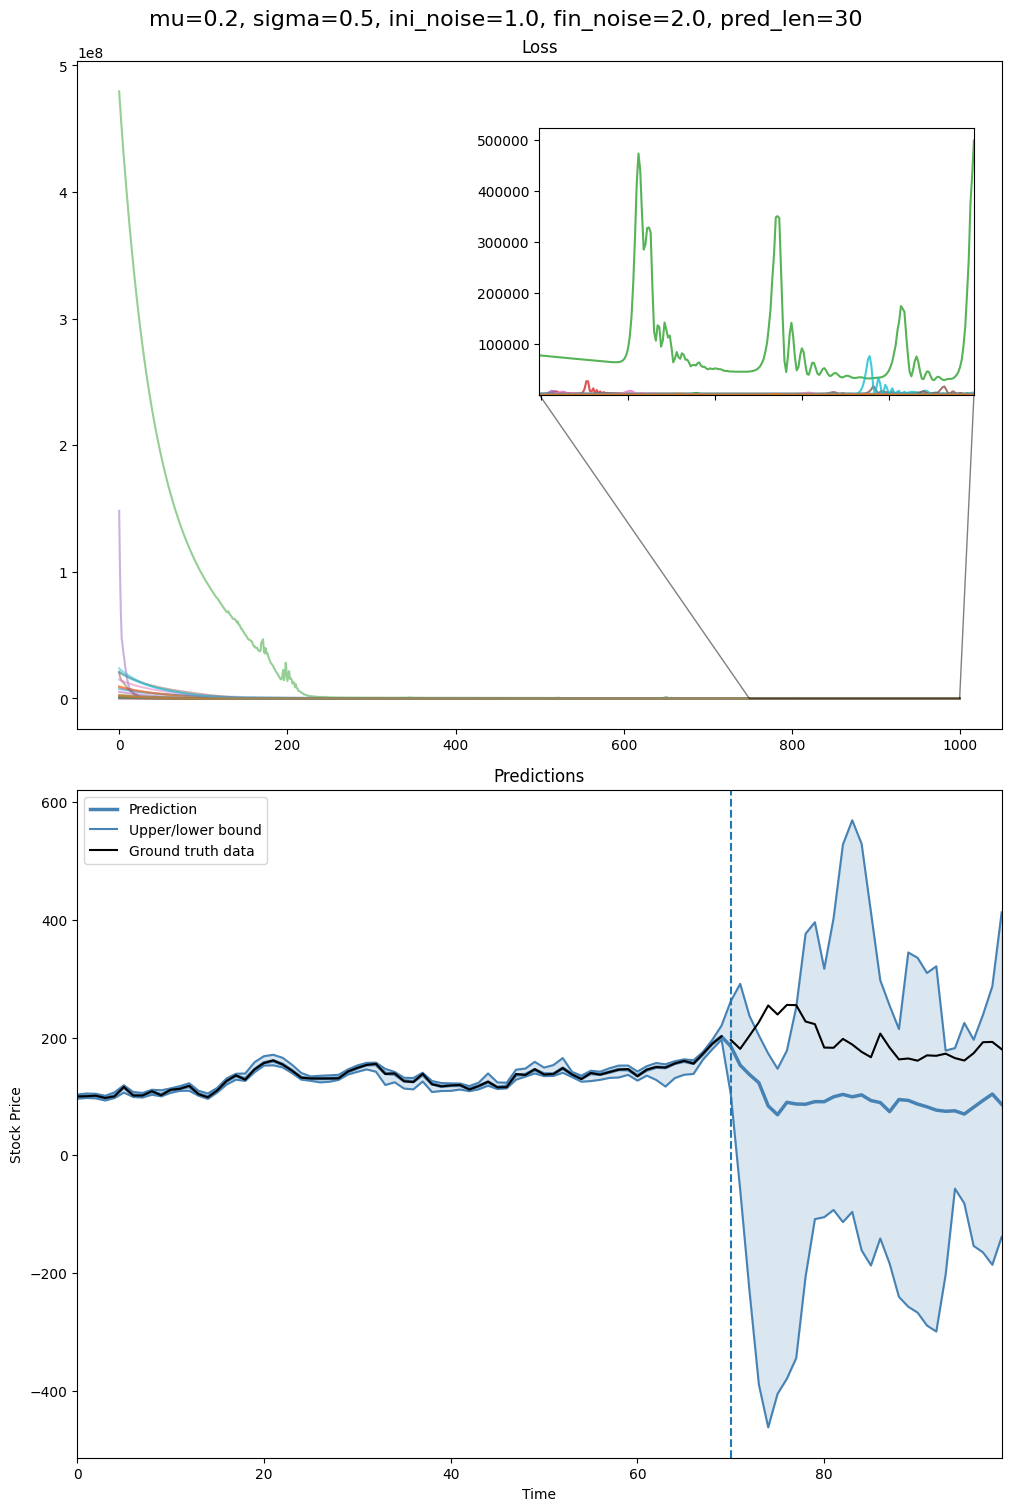

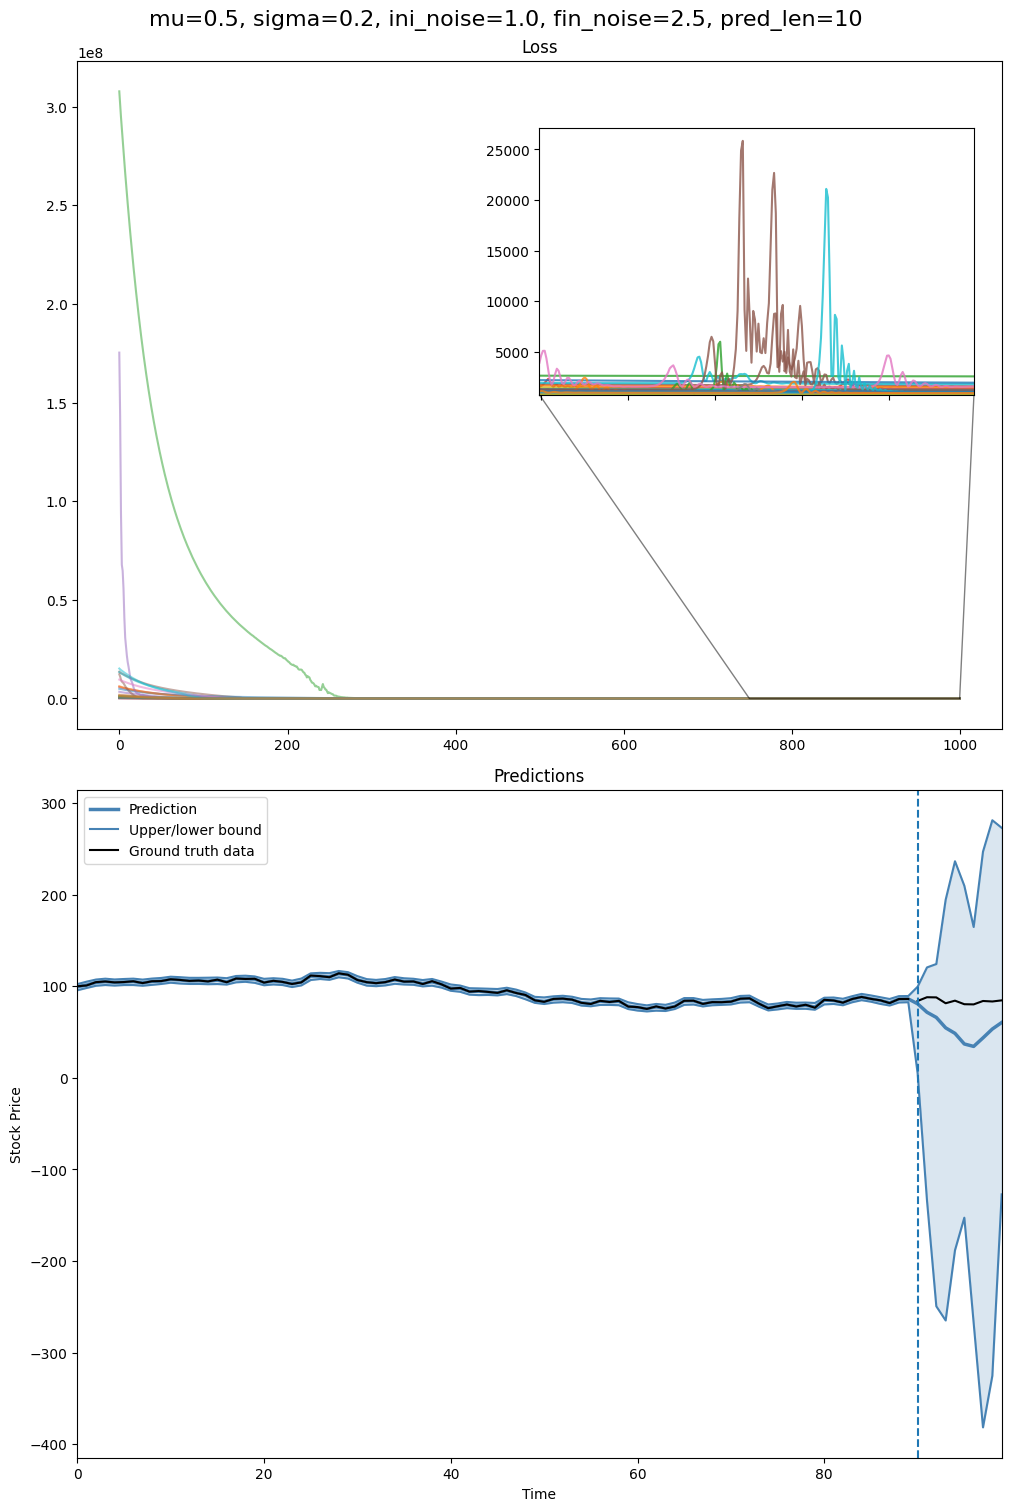

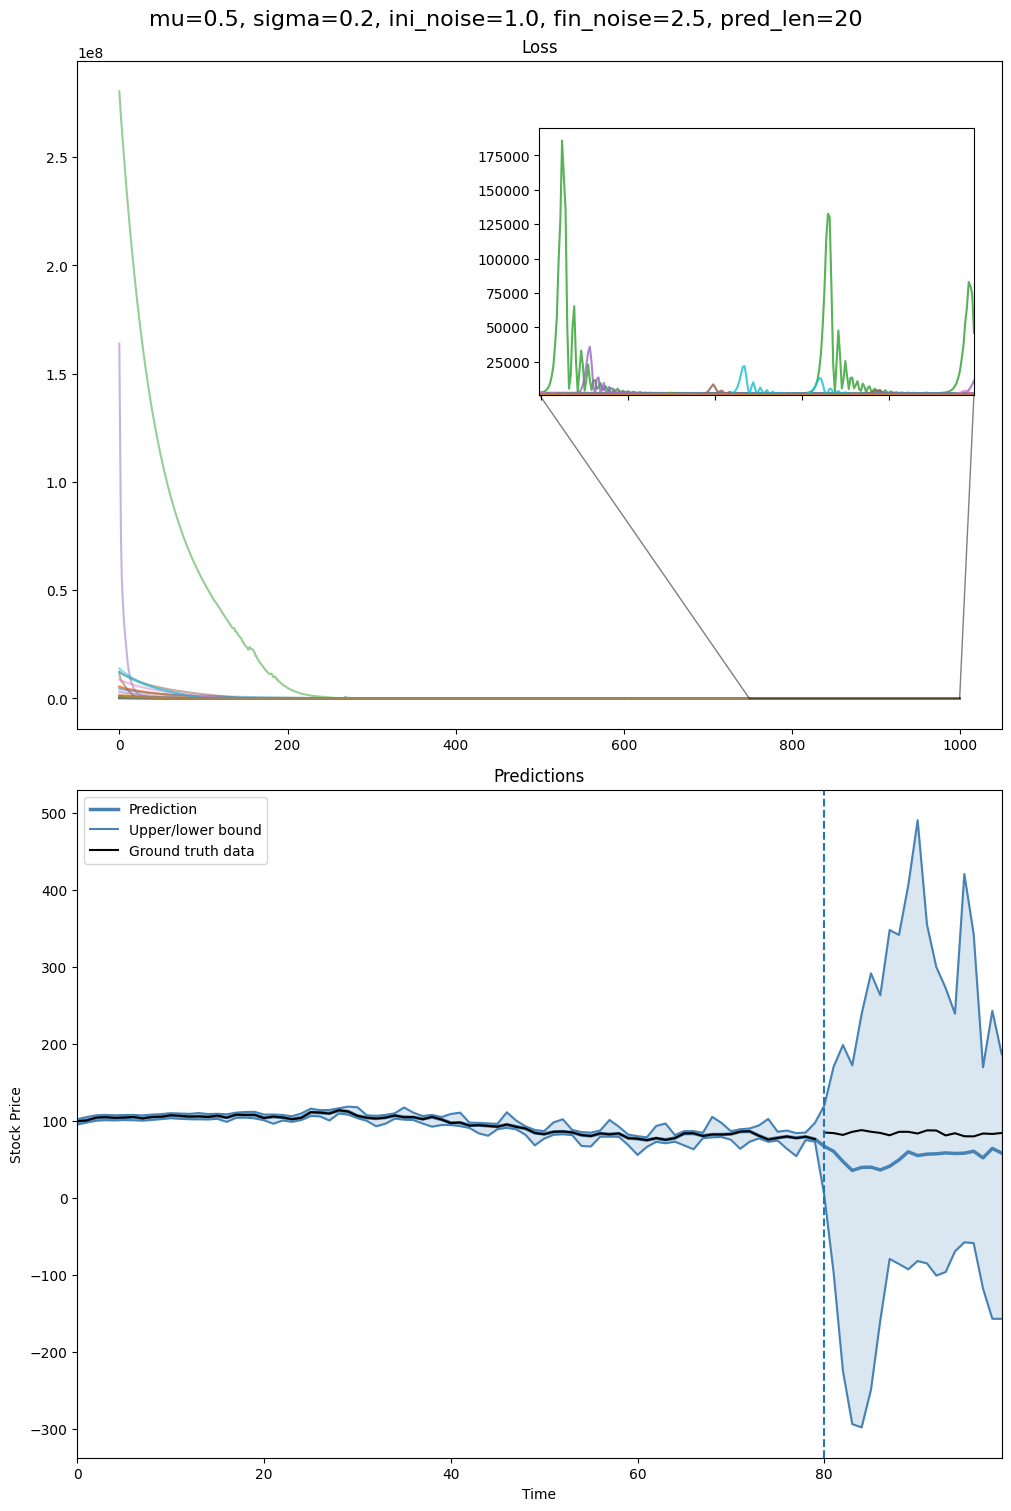

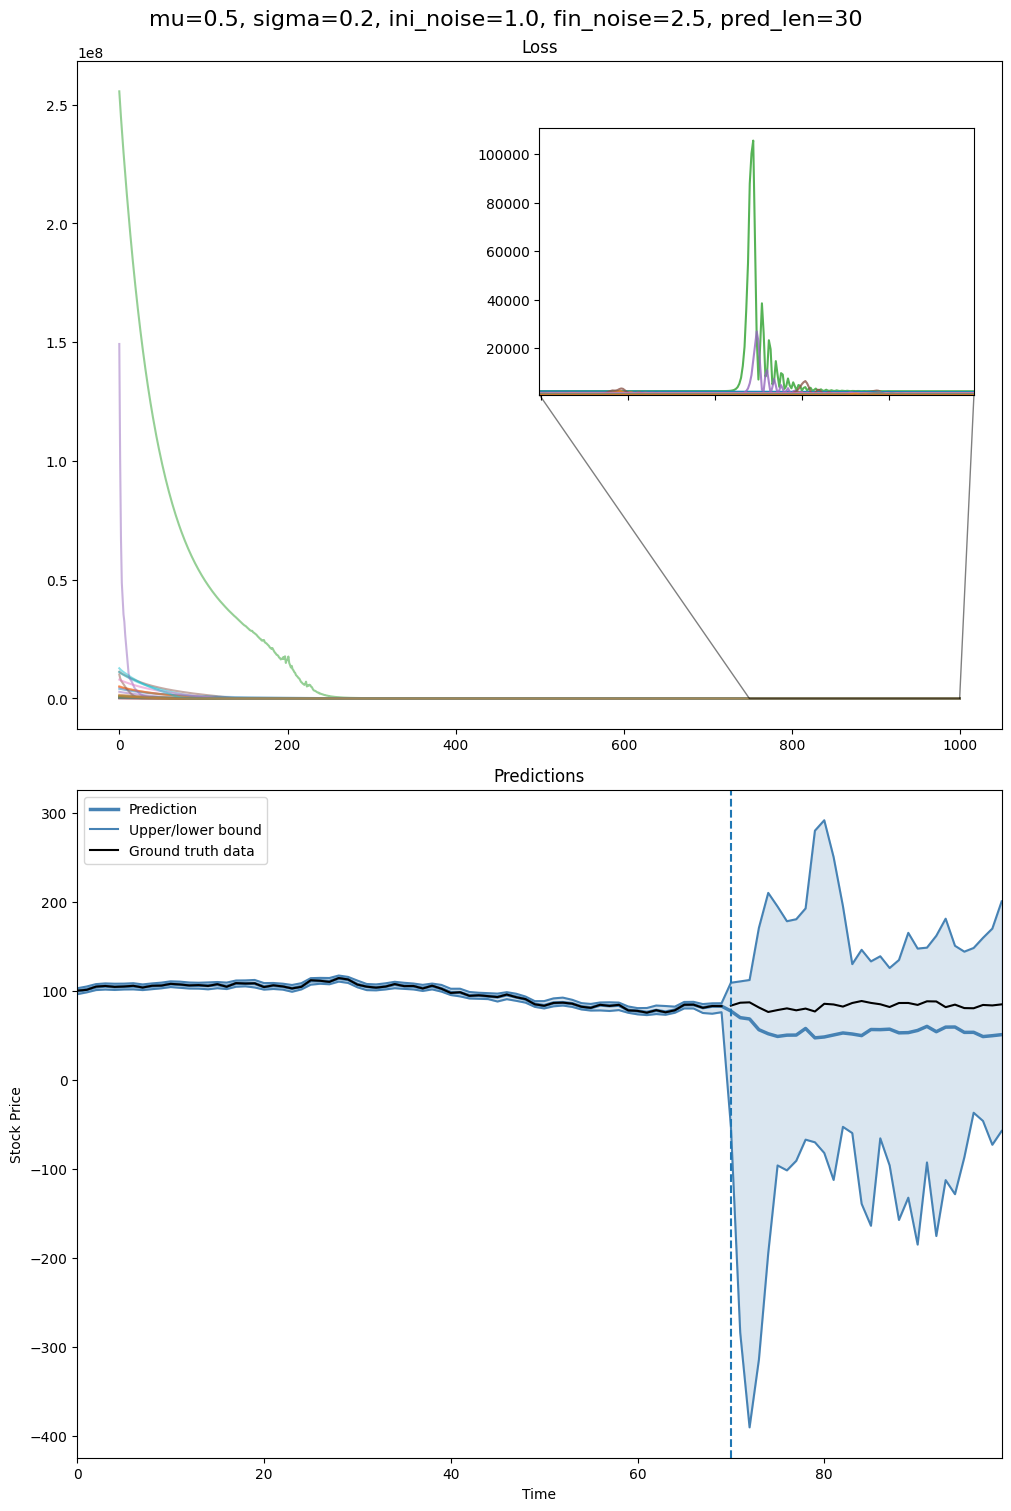

   (mu, sigma, ini_noise, fin_noise, pred_len)    Average MSE
0                    (-0.1, 0.3, 1.5, 2.0, 10)      40.728266
1                    (-0.1, 0.3, 1.5, 2.0, 20)      27.866697
2                    (-0.1, 0.3, 1.5, 2.0, 30)      38.910242
3                    (-0.5, 0.2, 1.0, 2.5, 10)     689.556726
4                    (-0.5, 0.2, 1.0, 2.5, 20)     152.143422
5                    (-0.5, 0.2, 1.0, 2.5, 30)     137.908460
6                    (-0.8, 0.2, 1.5, 2.0, 10)     418.209859
7                    (-0.8, 0.2, 1.5, 2.0, 20)      29.213360
8                    (-0.8, 0.2, 1.5, 2.0, 30)     106.927100
9                    (-0.8, 0.2, 1.0, 2.0, 10)     174.500787
10                   (-0.8, 0.2, 1.0, 2.0, 20)      52.530686
11                   (-0.8, 0.2, 1.0, 2.0, 30)      16.821872
12                    (0.1, 0.5, 1.5, 2.0, 10)    2047.606781
13                    (0.1, 0.5, 1.5, 2.0, 20)    2357.386992
14                    (0.1, 0.5, 1.5, 2.0, 30)    2314.832431
15      

In [8]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import random

from autobnn import estimators, operators, kernels, likelihoods, training_util

# Seed for reproducibility
seed = jax.random.PRNGKey(0)

# Read the simulated GBM data
df_gbm = pd.read_csv('simulated_gbm_paths_with_increasing_noise.csv')

# Get unique combinations of mu, sigma, initial_noise_factor, and final_noise_factor
combinations = df_gbm[['mu', 'sigma', 'initial_noise_factor', 'final_noise_factor']].drop_duplicates().values

# User-defined input to choose number of combinations to test
#num_combinations_to_test = int(input("Enter the number of combinations to test: "))

# Ensure the number is not greater than the available unique combinations
num_combinations_to_test = 10

# Sample the specified number of combinations
random.seed(42)
sampled_combinations = random.sample(list(combinations), num_combinations_to_test)

# List of different prediction lengths to try
prediction_lengths = [10, 20, 30]

# Dictionary to store MSE for each combination and prediction length
mse_summary = {}

# Initialize the AutoBNN model components
def initialize_autobnn_model(x_scale):
    one_year = jnp.array(12. / x_scale, dtype=jnp.float32)  # monthly data
    smooth_trend = kernels.ExponentiatedQuadraticBNN(
        amplitude_scale=4., length_scale_scale=one_year * 4.)

    seasonal = operators.Multiply(bnns=[
        kernels.PeriodicBNN(period=one_year, going_to_be_multiplied=True),
        kernels.ExponentiatedQuadraticBNN(amplitude_scale=4., length_scale_scale=one_year, going_to_be_multiplied=True)
    ])

    medium_term = kernels.ExponentiatedQuadraticBNN(length_scale_scale=one_year)

    likelihood = likelihoods.NormalLikelihoodLogisticNoise(log_noise_scale=0.1)

    kernel = operators.WeightedSum(
        likelihood_model=likelihood,
        bnns=[smooth_trend, medium_term, seasonal]
    )

    estimator = estimators.AutoBnnMapEstimator(
        model_or_name=kernel,
        likelihood_model='normal_likelihood_logistic_noise',
        seed=jax.random.PRNGKey(42),
        width=50,
        num_iters=1000,
        num_particles=32,
        learning_rate=0.01
    )

    return estimator

# Iterate over each (mu, sigma, initial_noise_factor, final_noise_factor) combination
for mu, sigma, ini_noise, fin_noise in sampled_combinations:
    # Filter the DataFrame for the current combination
    df_filtered_comb = df_gbm[(df_gbm['mu'] == mu) & (df_gbm['sigma'] == sigma) & 
                              (df_gbm['initial_noise_factor'] == ini_noise) & (df_gbm['final_noise_factor'] == fin_noise)]
    
    # Get unique paths for the current combination and select one path
    paths = df_filtered_comb['path'].unique()
    path = random.choice(paths)
    
    for forecastlength in prediction_lengths:
        # Filter the DataFrame for the current path
        df_filtered = df_filtered_comb[df_filtered_comb['path'] == path]
        
        # Extract time points and stock prices
        time_points = [col for col in df_filtered.columns if col.startswith('t_')]
        stock_prices = df_filtered[time_points].values.flatten()
        
        # Prepare training and testing data
        train_size = len(stock_prices) - forecastlength
        x_train, y_train = np.arange(train_size), stock_prices[:train_size]
        x_test, y_test = np.arange(train_size, len(stock_prices)), stock_prices[train_size:]

        # Combine x_train and x_test for full range predictions
        x_full = np.concatenate([x_train, x_test])
        y_full = np.concatenate([y_train, y_test])

        # Scale for time data
        x_scale = x_train.max()

        # Initialize the AutoBNN model
        estimator = initialize_autobnn_model(x_scale)

        # Fit the model
        estimator.fit(x_train[..., None], y_train[..., None])

        # Predict for the full range
        params = estimator.params_
        kernel = estimator.net_
        preds = jax.vmap(lambda p: kernel.apply(p, x_full[..., None]))(params)

        # Sample draws to get percentiles
        pred_seed = jax.random.PRNGKey(42)
        draws = estimator.likelihood_.sample(params['params'], preds.squeeze(), seed=pred_seed, sample_shape=100)
        low, mid, p90, hi = jnp.percentile(draws.squeeze(), jnp.array([2.5, 50., 90., 97.5]), axis=(0, 1))

        # Calculate MSE for the current combination, path, and prediction length
        mse = mean_squared_error(stock_prices[-forecastlength:], mid[-forecastlength:])
        
        # Store MSE in the summary dictionary
        key = (mu, sigma, ini_noise, fin_noise, forecastlength)
        if key not in mse_summary:
            mse_summary[key] = []
        mse_summary[key].append(mse)
    
        # Plot the results for the selected path using training_util.plot_results
        plot = training_util.plot_results(
            dates_preds=x_full,
            preds=preds,
            dates_test=x_test,
            y_test=y_test,
            p2_5=low,
            p50=mid,
            p97_5=hi,
            dates_train=x_train,
            y_train=y_train,
            diagnostics=estimator.diagnostics_,
            log_scale=False,
            show_particles=False,
            left_limit=200,
            right_limit=len(stock_prices)
        )
        plot.set_size_inches(10, 15)
        plot.axes[1].set_xlabel("Time")
        plot.axes[1].set_ylabel("Stock Price")
        plt.suptitle(f"mu={mu}, sigma={sigma}, ini_noise={ini_noise}, fin_noise={fin_noise}, pred_len={forecastlength}", fontsize=16)
        plt.show()

# Calculate average MSE for each combination and prediction length
avg_mse_summary = {k: np.mean(v) for k, v in mse_summary.items()}

# Display the summary of MSE
mse_df = pd.DataFrame(avg_mse_summary.items(), columns=['(mu, sigma, ini_noise, fin_noise, pred_len)', 'Average MSE'])
print(mse_df)
